# **TO GRANT OR NOT TO GRANT: DECIDING ON COMPENSATION BENEFITS - PART 3: DATA PRE-PROCESSING, FEATURE SELECTION, MODEL ASSESSMENT AND EVALUATION**

[<font color='steelblue'>1. - __Data Pre-Processing__</font>](#one-bullet) <br>
    [<font color='steelblue'>1.1. - Imports and Initial Transformations</font>](#two-bullet) <br>
    [<font color='steelblue'>1.2. - Data Cleaning</font>](#three-bullet) <br>
    [<font color='steelblue'>1.3. - Missing Values</font>](#four-bullet) <br>
    [<font color='steelblue'>1.4. - Simple Encoding</font>](#five-bullet) <br>
    [<font color='steelblue'>1.5. - Pipeline Preparation</font>](#six-bullet) <br>

[<font color='steelblue'>2. - __Feature Selection__</font>](#seven-bullet) <br>
    [<font color='steelblue'>2.1. - Spearman Correlation</font>](#eight-bullet) <br>
    [<font color='steelblue'>2.2. - XGBoost</font>](#nine-bullet) <br>
    [<font color='steelblue'>2.3. - Decision Trees</font>](#ten-bullet) <br>

[<font color='steelblue'>3. - __Model Assessment__</font>](#eleven-bullet) <br>
    [<font color='steelblue'>3.1. - Pre Model</font>](#twelve-bullet) <br>
    [<font color='steelblue'>3.2. - XGBoost</font>](#thirteen-bullet) <br>
    [<font color='steelblue'>3.3. - Neural Network</font>](#fourteen-bullet) <br>
    [<font color='steelblue'>3.4. - Decision Tree</font>](#fifteen-bullet) <br>
    [<font color='steelblue'>3.5. - Logistic Regression</font>](#sixteen-bullet) <br>
    [<font color='steelblue'>3.6. - Random Forest</font>](#seventeen-bullet) <br>
    [<font color='steelblue'>3.7. - Naive Bayes</font>](#eighteen-bullet) <br>
    [<font color='steelblue'>3.8. - Stacking: Logistic Regression and Naive Bayes</font>](#nineteen-bullet) <br>

[<font color='steelblue'>4. - __Model Evaluation__</font>](#twenty-bullet) <br>
    [<font color='steelblue'>4.1. - Accuracy Macro, Precision Macro, Recall Macro, F1 Macro</font>](#twentyone-bullet) <br>
    [<font color='steelblue'>4.2. - Prediction Submission</font>](#twentytwo-bullet) <br>

<a class="anchor" id="one-bullet"> 
<d style="color:white;">

## 1. Data Pre-Processing
</a> 
</d>   

<a class="anchor" id="two-bullet"> 
<d style="color:white;">

### 1.1. Imports and Initial Transformations
</a> 
</d>   

In [234]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from collections import Counter

from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import classification_report, make_scorer, f1_score, recall_score, precision_score, confusion_matrix, accuracy_score

In [235]:
# setting the options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf)

import warnings
warnings.filterwarnings("ignore")

In [236]:
df_dict = {
    'train': 'df',
    'test': 'df_test'
}

for name, dataframe in df_dict.items():
    # open the json with the dataframe datatypes
    with open(f'{name}_dtypes_visual_exploration.json', 'r') as f:
        dtypes = json.load(f)

    # save the column data type mappings
    dtype_mapping = {}
    date_cols = []
    for col, dtype in dtypes.items():
        if dtype == 'datetime64[ns]':
            dtype_mapping[col] = 'object'
            date_cols.append(col)
        else:
            dtype_mapping[col] = dtype

    # import the data with specified datatypes
    globals()[dataframe] = pd.read_csv(
        f'{name}_data_visual_exploration.csv'
        ,sep=','
        ,index_col=0
        ,dtype=dtype_mapping
    )

    # set the date columns datatype
    for date in date_cols:
        globals()[dataframe][date] = pd.to_datetime(globals()[dataframe][date])

# to avoid the 'is not defined' warning
df = df
df_test = df_test

<a class="anchor" id="three-bullet"> 
<d style="color:white;">

### 1.2. Data Cleaning
</a> 
</d>   

As we previously mentioned, there are some columns with weird values:
- **Age at Injury**: multiple values below 14, which is the minimum legal age to work in the USA
- **WCIO Part Of Body Code**: has a negative value

Before we go any further, let's try to tackle these issues.

#### 1.2.1. Age at Injury

In [237]:
df.loc[df['Age at Injury'] < 14, 'Age at Injury'] = np.nan

In [238]:
df_test.loc[df_test['Age at Injury'] < 14, 'Age at Injury'] = np.nan

In [239]:
df.loc[
    (df['Age at Injury'] < 14) & (df['Accident Date'].isna() | df['Birth Year'].isna()), 
    'Age at Injury'
] = np.nan

In [240]:
df_test.loc[
    (df_test['Age at Injury'] < 14) & (df_test['Accident Date'].isna() | df_test['Birth Year'].isna()), 
    'Age at Injury'
] = np.nan

As discussed in the notebook 'Part1-InitialInspection.ipynb', these values cannot yet be fixed, since we are trying to fix them using mathematical logic. Therefore, we will come back to fixing these values after we perform data imputation on the 'Accident Date' and 'Birth Year' columns. If there still are any inconsistent values in the test data, we will set them as NaN and impute them later.

#### 1.2.2. WCIO Part Of Body Code

In [241]:
len(df[df['WCIO Part Of Body Code'] < 0])

42011

In [242]:
df[df['WCIO Part Of Body Code'] < 0]['WCIO Part Of Body Code'].unique()

<IntegerArray>
[-9]
Length: 1, dtype: Int64

In [243]:
df_test[df_test['WCIO Part Of Body Code'] < 0]['WCIO Part Of Body Code'].unique()

<IntegerArray>
[-9]
Length: 1, dtype: Int64

All negative values are the same value - let's check if there are any values '9' or if we can simply convert these values to its absolute value.

In [244]:
len(df[df['WCIO Part Of Body Code'] == 9])

0

In [245]:
len(df_test[df_test['WCIO Part Of Body Code'] == 9])

0

As there are no values that take the value '9', we will convert the negative values to the absolute value

In [246]:
df['WCIO Part Of Body Code'] = np.where(
    # we select only the rows that meet the necessary conditions
    (df['WCIO Part Of Body Code'] < 0) & (df['WCIO Part Of Body Code'].notna()),
    # if conditions are met, we calculate the new value
    df['WCIO Part Of Body Code'].abs(),
    # otherwise, we keep the original value
    df['WCIO Part Of Body Code']
)

In [247]:
len(df[df['WCIO Part Of Body Code'] < 0])

0

In [248]:
df_test['WCIO Part Of Body Code'] = np.where(
    # we select only the rows that meet the necessary conditions
    (df_test['WCIO Part Of Body Code'] < 0) & (df_test['WCIO Part Of Body Code'].notna()),
    # if conditions are met, we calculate the new value
    df_test['WCIO Part Of Body Code'].abs(),
    # otherwise, we keep the original value
    df_test['WCIO Part Of Body Code']
)

In [249]:
len(df_test[df_test['WCIO Part Of Body Code'] < 0])

0

<a class="anchor" id="four-bullet"> 
<d style="color:white;">

### 1.3. Missing Values
</a> 
</d>  

In [250]:
# calculate the number of NaNs for each column
nan_counts = df.isna().sum()

# get the total number of rows
total_rows = df.shape[0]

# calculate the percentage of NaN values for each column
percentage_nans = (nan_counts / total_rows) * 100

# format the percentages with '%' sign
percentage_nans = percentage_nans.apply(lambda x: f"{x:.2f}%")

# combine all the information into a DataFrame
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts
    , 'Total Values': [total_rows] * len(nan_counts)
    , 'Percentage NaN': percentage_nans
})

display(nan_summary)

,NaN Count,Total Values,Percentage NaN
Accident Date,3688,574022,0.64%
Age at Injury,5415,574022,0.94%
Alternative Dispute Resolution,0,574022,0.00%
Assembly Date,0,574022,0.00%
Attorney/Representative,0,574022,0.00%
Average Weekly Wage,28651,574022,4.99%
Birth Year,31018,574022,5.40%
C-2 Date,14559,574022,2.54%
C-3 Date,386781,574022,67.38%
Carrier Name,0,574022,0.00%


In [251]:
missing_values = [
    'Accident Date'
    , 'Average Weekly Wage'
    , 'Birth Year'
    #, 'C-2 Date'  # missing form could have relationship with the target
    #, 'C-3 Date'  # missing form could have relationship with the target
    #, 'First Hearing Date'  # missing values means no hearing has held
    , 'Gender'
    #, 'IME-4 Count'  # missing form could have relationship with the target
    , 'Industry Code'
    , 'WCIO Cause of Injury Code'
    , 'WCIO Nature of Injury Code'
    , 'WCIO Part Of Body Code'
    , 'Zip Code'
    , 'Days Difference'
]

In [252]:
# calculate the number of NaNs for each column
nan_counts = df_test.isna().sum()

# get the total number of rows
total_rows = df_test.shape[0]

# calculate the percentage of NaN values for each column
percentage_nans = (nan_counts / total_rows) * 100

# format the percentages with '%' sign
percentage_nans = percentage_nans.apply(lambda x: f"{x:.2f}%")

# combine all the information into a DataFrame
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts
    , 'Total Values': [total_rows] * len(nan_counts)
    , 'Percentage NaN': percentage_nans
})

display(nan_summary)

,NaN Count,Total Values,Percentage NaN
Accident Date,2444,387975,0.63%
Age at Injury,3123,387975,0.80%
Alternative Dispute Resolution,0,387975,0.00%
Assembly Date,0,387975,0.00%
Attorney/Representative,0,387975,0.00%
Average Weekly Wage,19204,387975,4.95%
Birth Year,20301,387975,5.23%
C-2 Date,9134,387975,2.35%
C-3 Date,302759,387975,78.04%
Carrier Name,0,387975,0.00%


The columns from the test data that contain missing values are the same as the ones from the train data, with the addition of the descriptive columns, which we had removed from the train data.

We will not impute missing values in the commented columns, as per the explainations in the comments

<a class="anchor" id="five-bullet"> 
<d style="color:white;">

### 1.4. Simple Encoding
</a> 
</d>  

In [253]:
binary_columns = ['Alternative Dispute Resolution', 'Attorney/Representative', 'Gender', 'COVID-19 Indicator']

In [254]:
for col in binary_columns:
    display(df[col].value_counts())
    display(df_test[col].value_counts())

Alternative Dispute Resolution
N    571408
Y      2609
U         5
Name: count, dtype: int64

Alternative Dispute Resolution
N    386314
Y      1660
U         1
Name: count, dtype: int64

Attorney/Representative
N    392291
Y    181731
Name: count, dtype: int64

Attorney/Representative
N    306476
Y     81499
Name: count, dtype: int64

Gender
M    335216
F    234049
Name: count, dtype: int64

Gender
M    215343
F    167019
Name: count, dtype: int64

COVID-19 Indicator
N    546504
Y     27518
Name: count, dtype: int64

COVID-19 Indicator
N    385434
Y      2541
Name: count, dtype: int64

Before we proceed with the encoding of these features, let us replace the value 'U' in 'Alternative Dispute Resolution', by setting it as NaN

In [255]:
df.loc[df['Alternative Dispute Resolution'] == 'U', 'Alternative Dispute Resolution'] = np.nan
df_test.loc[df_test['Alternative Dispute Resolution'] == 'U', 'Alternative Dispute Resolution'] = np.nan

In [256]:
# Encoding binary features
for col in binary_columns:
    df[col] = df[col].map({'Y': 1, 'N': 0, 'M': 1, 'F': 0})
    df_test[col] = df_test[col].map({'Y': 1, 'N': 0, 'M': 1, 'F': 0})

In [257]:
def encode_dates(df, date_columns):
    for col in date_columns:
        df[f'{col}_year'] = df[col].apply(lambda x: x.year if pd.notnull(x) else np.nan)
        df[f'{col}_month'] = df[col].apply(lambda x: x.month if pd.notnull(x) else np.nan)
        df[f'{col}_day'] = df[col].apply(lambda x: x.day if pd.notnull(x) else np.nan)

    # Drop the original date columns
    df.drop(columns=date_columns, inplace=True)

In [258]:
date_features = [
    'Accident Date'
    , 'Assembly Date'
    , 'C-2 Date'
    , 'C-3 Date'
    , 'First Hearing Date'
]

In [259]:
# Apply the transformation
encode_dates(df, date_features)
encode_dates(df_test, date_features)

<a class="anchor" id="six-bullet"> 
<d style="color:white;">

### 1.5. Pipeline Preparation
</a> 
</d>  

In [260]:
X = df.drop(columns=['Claim Injury Type', 'Agreement Reached'])
y = df['Claim Injury Type']

Outliers Treatment - Capping

In [261]:
class ClipOutliersMulti(BaseEstimator, TransformerMixin):
    def __init__(self, quantile_limits=None, fixed_limits=None):
        """
        quantile_limits: dictionary with quantile-based limits. Example:
            {'Age at Injury': (0.01, 0.95), 'Birth Year': (0.01, 0.95)}

        fixed_limits: dictionary with fixed limits. Example:
            {'IME-4 Count': (None, 40)}
        """
        self.quantile_limits = quantile_limits or {}
        self.fixed_limits = fixed_limits or {}
        self.bounds = {}

    def fit(self, X, y=None):
        # Calculate limits based on quantiles
        for col, (q_lower, q_upper) in self.quantile_limits.items():
            self.bounds[col] = {
                'lower': X[col].quantile(q_lower) if q_lower is not None else None,
                'upper': X[col].quantile(q_upper) if q_upper is not None else None
            }

        # Add fixed limits
        for col, (lower, upper) in self.fixed_limits.items():
            self.bounds[col] = {
                'lower': lower,
                'upper': upper
            }
        return self

    def transform(self, X):
        # Clip values based on the calculated or fixed bounds
        X = X.copy()
        for col, limits in self.bounds.items():
            X[col] = X[col].astype(float).clip(lower=limits['lower'], upper=limits['upper'])
        return X

Frequency Encoder

In [262]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        """
        columns: List of categorical columns to apply frequency encoding.
        """
        self.columns = columns
        self.freq_encodings = {}

    def fit(self, X, y=None):
        # Check if X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("FrequencyEncoder requires a pandas DataFrame as input.")
        
        # Calculate frequency encoding for each column
        for col in self.columns:
            if col not in X.columns:
                raise ValueError(f"Column '{col}' not found in input DataFrame.")
            # Only normalized values (removes named indexes)
            self.freq_encodings[col] = X[col].value_counts(normalize=True).to_dict()
        
        return self

    def transform(self, X):
        # Check if X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("FrequencyEncoder requires a pandas DataFrame as input.")
        
        X = X.copy()
        # Apply frequency mapping
        for col in self.columns:
            if col in X.columns:
                X[col] = X[col].map(self.freq_encodings[col]).fillna(0)  # Fill non-mapped values with 0
        
        return X


Target Encoding

In [263]:
# Encoder for the target variable
target_encoder = OrdinalEncoder()

# Encode the target
y_encoded = target_encoder.fit_transform(y.to_numpy().reshape(-1, 1)).flatten()

Scalling and One-Hot Encoding

In [264]:
scaling_features = [
    'Age at Injury',
    'Average Weekly Wage',
    'Birth Year',
    'IME-4 Count',
    #'Industry Code',
    #'WCIO Cause of Injury Code',
    #'WCIO Nature of Injury Code',
    #'WCIO Part Of Body Code',
    'Number of Dependents',
    'Days Difference',
    'Accident Date_year', 'Accident Date_month', 'Accident Date_day',
    'Assembly Date_year', 'Assembly Date_month', 'Assembly Date_day',
    'C-2 Date_year', 'C-2 Date_month', 'C-2 Date_day',
    'C-3 Date_year', 'C-3 Date_month', 'C-3 Date_day',
    'First Hearing Date_year', 'First Hearing Date_month', 'First Hearing Date_day'
]

# List of features for One-Hot encoding
lowcard_features = ['Carrier Type', 'District Name', 'Medical Fee Region']

# Set up the preprocessor with scaling and OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), scaling_features),  # Apply scaling to the specified features
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), lowcard_features)  # Apply One-Hot encoding to low-cardinality features
    ],
    remainder='passthrough',  # Keep columns not specified
    verbose_feature_names_out=False  # Do not rename the columns
).set_output(transform="pandas")  # Ensure the output is a DataFrame

Missing Values Imputation - KNN

In [265]:
class SampleKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features, n_neighbors=5, weights='distance', sample_size=30000, random_state=20):
        """
        features: List of columns to be imputed.
        n_neighbors: Number of neighbors for the KNNImputer.
        sample_size: Number of samples for fitting the imputer.
        random_state: Random seed for sampling control.
        """
        self.features = features
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.sample_size = sample_size
        self.random_state = random_state
        self.imputer = KNNImputer(n_neighbors=self.n_neighbors, weights=self.weights)

    def fit(self, X, y=None):
        # Rebuild DataFrame if X is a NumPy array
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.features)

        # Select a sample to fit the imputer
        sample = X[self.features].sample(n=self.sample_size, random_state=self.random_state)
        self.imputer.fit(sample)
        
        return self

    def transform(self, X):
        # Rebuild DataFrame if X is a NumPy array
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.features)

        # Impute missing values
        X[self.features] = self.imputer.transform(X[self.features])
        
        return X

Missing Values Imputation - Zero Fill

In [266]:
class ZeroFillImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        """
        features: List of columns that should be filled with zero.
        """
        self.features = features

    def fit(self, X, y=None):
        # No fitting logic is required
        return self

    def transform(self, X):
        X = X.copy()
        X[self.features] = X[self.features].fillna(0)
        
        return X

Imputer Grid Search

In [267]:
class ImputerGridSearch:
    def __init__(self, pipeline, imputer_param_grid, random_state=20):
        """
        Initializes the ImputerGridSearch object.
        
        pipeline: The pipeline that includes the imputer and other steps.
        imputer_param_grid: Dictionary containing the parameter grid for the imputer.
        random_state: Random seed for reproducibility (default is 20).
        """
        self.pipeline = pipeline
        self.imputer_param_grid = imputer_param_grid
        self.random_state = random_state

    def perform_grid_search(self, data, cv, y):
        """
        Perform grid search on the pipeline with the imputer parameters.
        
        data: The input data for training.
        cv: Cross-validation strategy (KFold).
        y: The target variable (labels).
        
        Returns the best model found during grid search.
        """
        best_params = None
        best_score = float('-inf')

        # Define the parameter grid for the imputer step in the pipeline
        param_grid = {
            'imputer__n_neighbors': self.imputer_param_grid['n_neighbors'],  # Number of neighbors for KNN
            'imputer__weights': self.imputer_param_grid['weights']  # Weights for KNN imputation
        }

        # Set up GridSearchCV to search for the best hyperparameters
        grid_search = GridSearchCV(
            self.pipeline,  # The pipeline to be optimized
            param_grid,  # The parameter grid to search
            scoring='f1_macro',  # Evaluate using F1 score (macro average)
            cv=cv,  # Cross-validation strategy
            verbose=3,  # Display detailed information during the search
            n_jobs=-1  # Use all available CPU cores
        )

        # Perform grid search
        grid_search.fit(data, y)

        # Store the best parameters and best score found
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        # Print the results of the grid search
        print(f"Best Parameters: {best_params}")
        print(f"Best Test Score: {best_score:.4f}")

        # Return the pipeline with the best parameters
        return self.pipeline


<a class="anchor" id="seven-bullet"> 
<d style="color:white;">

## 2. Feature Selection
</a> 
</d>   

<a class="anchor" id="eight-bullet"> 
<d style="color:white;">

### 2.1. Spearman Correlation
</a> 
</d>  

In [268]:
class RemoveHighSpearmanCorrelation(BaseEstimator, TransformerMixin):
    def __init__(self, features, threshold=0.8):
        """
        Remove highly correlated variables based on Spearman correlation.

        Parameters:
        - features: List of numeric variables to be analyzed.
        - threshold: Limit above which variables will be considered correlated.
        """
        self.features = features
        self.threshold = threshold
        self.to_remove = []


    def fit(self, X, y=None):
        """
        Calculates the correlation and identifies the variables to be removed.

        Parameters:
        - X: Input DataFrame.
        - y: Ignored (for compatibility with sklearn).
        """
        # Calculate the correlation matrix for the specified variables
        corr_matrix = X[self.features].corr(method='spearman')
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Identify variables with high correlation
        self.to_remove = [
            column for column in upper_triangle.columns 
            if any(upper_triangle[column] > self.threshold)
        ]

        return self


    def transform(self, X):
        """
        Removes the identified variables.

        """
        return X.drop(columns=self.to_remove, errors='ignore')



<a class="anchor" id="nine-bullet"> 
<d style="color:white;">

### 2.2. XGBoost
</a> 
</d>  

In [269]:
class XGBFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_features=18, model=None, random_state=42):
        """
        num_features: Number of most important features to select.
        model: Model to be used for calculating feature importance.
        random_state: Seed for reproducibility.
        """
        self.num_features = num_features
        self.model = model if model else XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            scale_pos_weight=1,
            random_state=random_state,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
        self.random_state = random_state  # Adds random_state as an internal attribute
        self.top_features = None

    def fit(self, X, y):
        # Fit the model to calculate feature importance
        self.model.fit(X, y)
        # Select the N most important features
        feature_importances = pd.Series(self.model.feature_importances_, index=X.columns)
        self.top_features = feature_importances.nlargest(self.num_features).index
        
        return self

    def transform(self, X):
        # Return only the selected features
        return X[self.top_features]

<a class="anchor" id="ten-bullet"> 
<d style="color:white;">

### 2.3. Decision Trees
</a> 
</d>  

Feature selection with Decision Trees. By using the module __.feature_importances___ we can calculate the feature importance using the split criteria 'gini' and 'entropy'

In [270]:
class DT_FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, gini_threshold=0.005, entropy_threshold=0.005, random_state=42):
        """
        num_features: Maximum number of features to select.
        gini_threshold: Minimum importance threshold for the Gini criterion.
        entropy_threshold: Minimum importance threshold for the Entropy criterion.
        random_state: Seed for reproducibility.
        """
        
        self.gini_threshold = gini_threshold
        self.entropy_threshold = entropy_threshold
        self.random_state = random_state
        self.top_features = None

    def fit(self, X, y):
        # Model with Gini criterion
        gini_model = DecisionTreeClassifier(criterion='gini', random_state=self.random_state)
        gini_model.fit(X, y)
        gini_importance = pd.Series(gini_model.feature_importances_, index=X.columns)
        
        # Model with Entropy criterion
        entropy_model = DecisionTreeClassifier(criterion='entropy', random_state=self.random_state)
        entropy_model.fit(X, y)
        entropy_importance = pd.Series(entropy_model.feature_importances_, index=X.columns)

        # Combine the importances into a DataFrame
        feature_importances = pd.DataFrame({
            'gini': gini_importance,
            'entropy': entropy_importance
        })

        # Melt the DataFrame to long format and filter based on the thresholds
        feature_importances['feature'] = X.columns
        tidy = feature_importances.melt(id_vars='feature', var_name='criterion', value_name='importance')
        tidy = tidy[tidy['importance'] > 0]  # Remove zero importances

        # Filter features that pass the thresholds
        selected_features = tidy[((tidy['criterion'] == 'gini') & (tidy['importance'] > self.gini_threshold)) |
                                  ((tidy['criterion'] == 'entropy') & (tidy['importance'] > self.entropy_threshold))]

        # Sort by importance and select the N best features
        selected_features = selected_features.sort_values(by='importance', ascending=False)
        self.top_features = selected_features['feature'].unique()

        return self

    def transform(self, X):
        # Return only the selected features
        if self.top_features is None:
            raise RuntimeError("The fit method needs to be called before transform.")
        return X[self.top_features]

<a class="anchor" id="eleven-bullet"> 
<d style="color:white;">

## 3. Model Assessment
</a> 
</d>   

<a class="anchor" id="twelve-bullet"> 
<d style="color:white;">

### 3.1. Pre Model 
</a> 
</d>  

In [271]:
def ensure_dataframe(X):
    # Ensures that the input is a pandas DataFrame; if not, converts it to one
    if not isinstance(X, pd.DataFrame):
        return pd.DataFrame(X)
    
    return X


In [272]:
def inspect_columns(X):
    # Prints the list of columns after preprocessing
    print(f"Columns after preprocessor: {list(X.columns)}")
    return X

In [273]:
code_mapping = {
    'Industry Code': {
        'Primary Industry': [11, 21, 22]  # Raw materials
        ,'Secondary Industry': [23, 31]  # Manufacturing and Production
        ,'Tertiary Industry': [42, 44, 48, 53]  # Services
        ,'Quaternary Industry': [51, 52, 54, 55]  # Knowledge-based
        ,'Social and Public Services': [61, 62, 92]
        ,'Recreational and Hospitality Services': [71, 72]
        ,'Other Services': [56, 81]
    }
    ,'WCIO Part Of Body Code': {
        'Head': range(10, 20)
        ,'Neck': range(20, 27)
        ,'Upper Extremities': range(30, 40)
        ,'Trunk': [*range(40, 50), *range(60, 64)]
        ,'Lower Extremities': range(50, 59)
        ,'Multiple Body Parts': [9, *range(64, 67), 90, 91, 99]
    }
    ,'WCIO Nature of Injury Code': {
        'Specific Injury': [1, 2, 3, 4, 7, 10, 13, 16, 19, 22, 25, 28, 30, 31, 32, 34, 36, 37, 38, 40, 41, 42, 43, 46, 47, 49, 52, 53, 54, 55, 58, 59]
        ,'Occupational Disease or Cumulative Injury': [*range(60, 81), 83]
        ,'Multiple Injuries': [90, 91]
    }
    ,'WCIO Cause of Injury Code': {
        'Burn or Scald - Heat or Cold Exposures - Contact With': [*range(1, 10), 11, 14, 84]
        ,'Caught In, Under or Between': [10, 12, 13, 20]
        ,'Cut, Puncture, Scrape Injured By': range(15, 20)
        ,'Fall, Slip or Trip Injury': range(25, 34)
        ,'Motor Vehicle': [40, 41, *range(45, 49), 50]
        ,'Strain or Injury By': [*range(52, 62), 97]
        ,'Stricking Against or Stepping On': range(65, 71)
        ,'Struck or Injured By': [*range(74, 82), 85, 86]
        ,'Rubbed or Abraded By': [94, 95]
        ,'Miscellaneous Causes': [82, 83, *range(87, 92), 93, 96, 98, 99]
    }    
}

Mappings Reference:
- https://www.dir.ca.gov/dwc/WCIS/Part_of_Body.pdf
- https://www.dir.ca.gov/dwc/WCIS/Nature_Of_Injury.pdf
- https://www.dir.ca.gov/dwc/WCIS/Cause_Of_Injury.pdf

In [274]:
class CodeMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapping_dict):
        """
        Initializes the CodeMapper with a dictionary containing the mapping information.
        """
        self.mapping_dict = mapping_dict


    def fit(self, X, y=None):
        return self
    

    def transform(self, X):
        """
        Transforms the input data by applying the specified mappings to the relevant columns.
        """
        X_transformed = X.copy()

        # Loop through the columns and apply the reverse mappings
        for col, mappings in self.mapping_dict.items():
            # Reverse the mapping to map values to their corresponding keys
            reverse_mapping = {
                val: key 
                for key, values in mappings.items() 
                for val in values
            }

            # Apply the mapping to the column and keep the original value if no mapping is found
            X_transformed[col] = X_transformed[col].map(reverse_mapping).fillna(X_transformed[col])

        return X_transformed


In [275]:
class ConvertDataType(BaseEstimator, TransformerMixin):
    def __init__(self, dtype, columns):
        """
        Initializes the transformer to change the data type of specified columns.
        """
        self.dtype = dtype
        self.columns = columns


    def fit(self, X, y=None):
        return self
    

    def transform(self, X):
        """
        Transforms the data by converting specified columns to the target data type.
        """
        X = X.copy()

        for col in self.columns:
            X[col] = X[col].astype(self.dtype)

        return X


In [276]:
class FixCodes(BaseEstimator, TransformerMixin):
    def __init__(self, valid_codes, columns):
        """
        Initializes the transformer to fix codes based on the closest valid value.
        """
        self.valid_codes = valid_codes
        self.columns = columns


    def fit(self, X, y=None):
        return self
    

    def transform(self, X):
        """
        Transforms the data by replacing invalid codes with the closest valid value.
        """
        def closest_valid_value(col, val):
            """
            Finds the closest valid value for a given invalid code.
            """
            valid_values = []

            for category, values in self.valid_codes[col].items():
                valid_values.extend(values)

            if val in valid_values:
                return val
            else:
                return min(valid_values, key=lambda x: abs(x - val))
            

        X_transformed = X.copy()

        for col in self.columns:
            X_transformed[col] = X[col].apply(lambda x: closest_valid_value(col, x))

        return X_transformed


In [277]:
# inicializing kf with StratifiedKFold that will be used in the rest of the notebook
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [278]:
def evaluate_feature_intervals(pipeline, X, y, feature_intervals, scoring='f1_macro', cv=5):
    """
    Evaluates different numbers of features in the pipeline using Stratified K-Fold CV.
    
    Parameters:
    - pipeline: Sklearn pipeline with EmbeddedFeatureSelector.
    - X: DataFrame of features.
    - y: Target variable.
    - feature_intervals: List of numbers of features to test.
    - scoring: Evaluation metric (default: 'f1_macro').
    - cv: Number of folds for cross-validation.
    
    Returns:
    - DataFrame with the results (n_features, mean_train_score, mean_val_score, overfit).
    """
    results = []
    
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    for num_features in feature_intervals:
        # Update the number of features in the selector within the pipeline
        pipeline.set_params(feature_selector__num_features=num_features)
        
        # Perform cross-validation with StratifiedKFold
        scores = cross_validate(
            pipeline, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=True
        )
        
        # Store the results
        results.append({
            'n_features': num_features,
            'mean_train_score': scores['train_score'].mean(),
            'mean_val_score': scores['test_score'].mean(),
            'overfit': abs(scores['train_score'].mean() - scores['test_score'].mean())
        })
    
    return pd.DataFrame(results)


In [279]:
def avg_score(model, X, y):
    """
    This function receives a model, the X and y data, and applies cross-validation
    using StratifiedKFold to calculate the F1 score for both training and validation.
    """
    
    # Lists to store the results of time and F1 score
    train_f1_scores = []
    val_f1_scores = []

    # Loop through the StratifiedKFold splits
    for train_index, val_index in kf.split(X, y):
        # Get the training and validation data for each split
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        # Train the model on the training data
        model.fit(X_train_fold, y_train_fold)

        # Calculate the F1-score for the training data
        train_predictions = model.predict(X_train_fold)
        train_f1 = f1_score(y_train_fold, train_predictions, average='macro')  # Adjusted for multiclass
        
        # Calculate the F1-score for the validation data
        val_predictions = model.predict(X_val_fold)
        val_f1 = f1_score(y_val_fold, val_predictions, average='macro')  # Adjusted for multiclass
        
        # Store the results in the lists
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

    # Calculate the averages of each metric
    avg_train_f1 = np.mean(train_f1_scores)
    avg_val_f1 = np.mean(val_f1_scores)

    # Return the results formatted
    return avg_train_f1, avg_val_f1


def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # For each model passed as an argument
    for arg in args:
        # Obtain the results provided by avg_score
        avg_train, avg_val = avg_score(arg, X, pd.DataFrame(y_encoded))
        # Store the results in the correct row
        df.iloc[count] = avg_train, avg_val
        count+=1
    return df


Before starting the process of testing models, we run a grid search to find the best parameters to use on the imputer, based on the f1 score macro on the target variable.

In [280]:
# # Hyperparameter grid for the imputer
# imputer_param_grid = {
#     'n_neighbors': [5, 10, 15],  # Number of neighbors for KNN imputation
#     'weights': ['uniform', 'distance']  # Weighting method for neighbors
# }

# Sample 30000 random samples from the data for imputation
# imp_X = X.copy().reset_index(drop=True).sample(30000, random_state=20)
# imp_y = y_encoded[imp_X.index.values]

# int64_columns = imp_X.select_dtypes(include='Int64').columns
# imp_X[int64_columns] = imp_X[int64_columns].astype(float)

# # Initialize the ImputerGridSearch class with a pipeline and the parameter grid
# imputer_search = ImputerGridSearch(
#     pipeline=Pipeline(steps=[  # Sequential pipeline of transformations and model fitting
#         ('clip_outliers', ClipOutliersMulti(
#             quantile_limits={  # Setting quantile-based limits for clipping outliers
#                 'Age at Injury': (0.01, 0.95),
#                 'Average Weekly Wage': (None, 0.75),
#                 'Birth Year': (0.01, 0.95),
#                 'Days Difference': (None, 0.80),
#             },
#             fixed_limits={  # Fixed limits for clipping outliers
#                 'IME-4 Count': (None, 40)
#             }
#         )),
#         ('preprocessor', preprocessor),  # Scaling and OneHot encoding
#         ('frequency_encoder', FrequencyEncoder(columns=[  # Encoding categorical features by frequency
#             'Carrier Name', 'County of Injury', 'Zip Code'
#         ])),
#         ('imputer', SampleKNNImputer(
#             features=[  # Features to be imputed
#                 'Alternative Dispute Resolution', 'Average Weekly Wage', 'Age at Injury', 'Birth Year',
#                 'Carrier Name', 'Gender', 'Industry Code', 'WCIO Cause of Injury Code',
#                 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
#                 'Accident Date_year', 'Accident Date_month', 'Accident Date_day', 'Days Difference'
#             ],
#             n_neighbors=10, sample_size=10000, random_state=20
#         )),
#         ('int_convert', ConvertDataType(dtype='int', columns=['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])),
#         ('fix_codes', FixCodes(valid_codes=code_mapping, columns=['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])),
#         ('zero_fill', ZeroFillImputer(features=[  # Filling missing values with zeros for specific columns
#             'IME-4 Count', 'C-2 Date_year', 'C-2 Date_month', 'C-2 Date_day',
#             'C-3 Date_year', 'C-3 Date_month', 'C-3 Date_day',
#             'First Hearing Date_year', 'First Hearing Date_month', 'First Hearing Date_day'
#         ])),
#         ('code_mapping', CodeMapper(code_mapping)),
#         ('oh_codes', ColumnTransformer(transformers=[
#             ('onehot', OneHotEncoder(
#                 sparse_output=False
#                 ,handle_unknown='ignore'
#                 ,drop='first'
#             ), ['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])
#         ], remainder='passthrough'  # Preserve unspecified columns
#         ,verbose_feature_names_out=False  # Do not rename columns
#         ).set_output(transform="pandas")),
#         ('model', XGBClassifier(  # The model used for classification
#             n_estimators=200,
#             max_depth=6,
#             learning_rate=0.1,
#             reg_alpha=5,
#             reg_lambda=10,
#             random_state=42
#         ))
#     ])
#     ,imputer_param_grid=imputer_param_grid  # Passing the hyperparameter grid for imputation
# )

# # Perform grid search on the pipeline using the defined cross-validation and sample data
# imputer_search.perform_grid_search(
#     data=imp_X,
#     cv=kf,
#     y=imp_y
# )

Now that we have found the parameters that return a higher f1 score macro, we define a variable which contains all the steps common to every model we shall test.

In [281]:
preproc_steps = [
    ('clip_outliers', ClipOutliersMulti(
            quantile_limits={
                'Age at Injury': (0.01, 0.95),
                'Average Weekly Wage': (None, 0.75),  
                'Birth Year': (0.01, 0.95),
                'Days Difference': (None, 0.80),
            },
            fixed_limits={
                'IME-4 Count': (None, 40)
            }
        )),
        ('preprocessor', preprocessor),  #Scalling and one hot encoding
        ('frequency_encoder', FrequencyEncoder(columns=[
            'Carrier Name', 'County of Injury', 'Zip Code'
        ])),
        ('imputer', SampleKNNImputer(
            features=[
                'Alternative Dispute Resolution', 'Average Weekly Wage', 'Age at Injury','Birth Year', 'Carrier Name', 'Gender',
                'Zip Code', 'Accident Date_year', 'Accident Date_month', 'Accident Date_day', 'Days Difference',
                'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
                'C-2 Missed Timing', 'C-3 Missed Timing', 'Log Average Weekly Wage', 'Log Birth Year', 'Log IME-4 Count'
            ],
            n_neighbors=5, weights='uniform', sample_size=1000, random_state=20
        )),
        ('int_convert', ConvertDataType(dtype='int', columns=['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])),
        ('fix_codes', FixCodes(valid_codes=code_mapping, columns=['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])),
        ('zero_fill', ZeroFillImputer(features=[
            'IME-4 Count', 'C-2 Date_year', 'C-2 Date_month', 'C-2 Date_day',
            'C-3 Date_year', 'C-3 Date_month', 'C-3 Date_day',
            'First Hearing Date_year', 'First Hearing Date_month', 'First Hearing Date_day'
        ])),
        ('code_mapping', CodeMapper(code_mapping)),
        ('oh_codes', ColumnTransformer(transformers=[
            ('onehot', OneHotEncoder(
                sparse_output=False
                ,handle_unknown='ignore'
                ,drop='first'
            ), ['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])
        ], remainder='passthrough'  # Preserve unspecified columns
        ,verbose_feature_names_out=False  # Do not rename columns
        ).set_output(transform="pandas"))
]

<a class="anchor" id="thirteen-bullet"> 
<d style="color:white;">

### 3.2. XGBoost
</a> 
</d>  

#### 3.2.1. Pipeline Construction with XGBoost

In [282]:
pipeline_XGB = Pipeline(steps=[
    *preproc_steps,
    ('feature_selector', XGBFeatureSelector(num_features=53)),  # Feature Selection
    ('model', XGBClassifier(  # Final Model
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        reg_alpha=5,
        reg_lambda=10,
        random_state=42,
    ))
])

How to decide the number of features on the XGBoost Feature Selector? We will anlyse the f1-macro scores on the train and test folds with the different number of features below on the notebook

#### 3.2.2. Deciding the number of features to mantain

Since testing every number of features would be very computationally expensive, we ran some ranges and we understood the best number would be between 50-60. With best number we mean the best combination between overfit and the f1-macro validation score. Since the f1-macro would not increase as much as overfit when the number of features was changed, we decided to keep a maximum of 2 or 3 percentual points of difference between scores to control overfit and then trying to maximize validation score, which was 53 features

In [283]:
# feature_intervals = range(45, 60)

# results_df = evaluate_feature_intervals(pipeline_XGB, X, y_encoded, feature_intervals, scoring='f1_macro', cv=5)

# results_df

In [284]:
feat_select = pd.read_csv('Feature Selection XGB')
feat_select

,Unnamed: 0,n_features,mean_train_score,mean_val_score,overfit
0,0,53,0.453409,0.431743,0.021666
1,1,54,0.454285,0.430338,0.023947
2,2,55,0.455603,0.431194,0.024409
3,3,56,0.455846,0.431260,0.024587
4,4,57,0.456972,0.432816,0.024156
5,5,58,0.456905,0.431282,0.025623


#### 3.2.3. Feature Importance

After running some tests we noticed that when implementing feature selection based on spearman correlation our model was overfitting more than without it. We are going to understand why by comparing the correlated features with the feature importance attributed by XGBoost

#### 3.2.4. Model-Based Feature Selection - XGBoost

In [285]:
# Process only the first fold and extract important features
features_first_fold = None

# Process only the first fold and extract important features
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_encoded)):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    # Fit the pipeline on the training set
    pipeline_XGB.fit(X_train, y_train)

    # Extract the feature selector and model from the pipeline
    feature_selector = pipeline_XGB.named_steps['feature_selector']
    model = pipeline_XGB.named_steps['model']

    # Get selected feature names from the feature selector
    selected_feature_names = feature_selector.top_features  # Use directly as names

    # Get feature importances from the model
    feature_importances = pd.Series(
        model.feature_importances_,
        index=selected_feature_names
    ).sort_values(ascending=False)

    # Display the features and their importances
    print(feature_importances)

    # Break after processing the first fold
    break



Log Average Weekly Wage                                                 0.206959
Average Weekly Wage                                                     0.146460
C-2 Missing                                                             0.118469
Attorney/Representative                                                 0.107266
Alternative Dispute Resolution                                          0.072183
Has IME-4 Report                                                        0.044110
WCIO Part Of Body Code_Trunk                                            0.032377
Has Hearing                                                             0.015991
Carrier Type_3A. SELF PUBLIC                                            0.013757
Carrier Type_UNKNOWN                                                    0.012830
COVID-19 Indicator                                                      0.012763
C-2 Missed Timing                                                       0.011936
IME-4 Count                 

Now we can understand why: spearman removes 'C-2 Date_year' which is the 14th most important variable, even if the relative importance to the model is not very big. For XGBoost we will stick to the feature importance attributed by the model itself

#### 3.2.5. Confusion Matrix

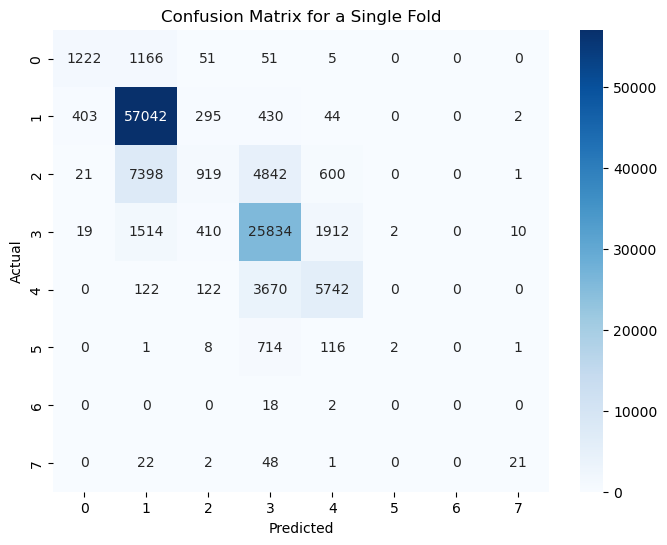

In [286]:
# Select the first fold
for train_idx, val_idx in kf.split(X, y_encoded):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
    
    # Fit the pipeline on the training fold
    pipeline_XGB.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_val_pred = pipeline_XGB.predict(X_val)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    
    # Display the matrix graphically
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pipeline_XGB.classes_, yticklabels=pipeline_XGB.classes_)
    plt.title("Confusion Matrix for a Single Fold")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    
    break

We predict the class 1 relatively well while the others not really, for example classes 5 and 6 are always predicted wrongly.

#### 3.2.6. F1-Macro, Recall-Macro and Precision-Macro

In [287]:
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro')
}

cv_results = cross_validate(
    pipeline_XGB,
    X,
    y_encoded,
    cv=kf,
    scoring=scoring,
    return_train_score=True
)

# F1-Macro
train_f1_scores = cv_results['train_f1_macro']
val_f1_scores = cv_results['test_f1_macro']
print("Train F1-Macro scores for each fold:", train_f1_scores)
print("Validation F1-Macro scores for each fold:", val_f1_scores)
print("Mean Train F1-Macro score:", train_f1_scores.mean())
print("Mean Validation F1-Macro score:", val_f1_scores.mean())
print("Std Dev Train F1-Macro score:", train_f1_scores.std())
print("Std Dev Validation F1-Macro score:", val_f1_scores.std())

# Recall-Macro
train_recall_scores = cv_results['train_recall_macro']
val_recall_scores = cv_results['test_recall_macro']
print("\nMean Train Recall-Macro score:", train_recall_scores.mean())
print("Mean Validation Recall-Macro score:", val_recall_scores.mean())
print("Std Dev Train Recall-Macro score:", train_recall_scores.std())
print("Std Dev Validation Recall-Macro score:", val_recall_scores.std())

# Precision-Macro
train_precision_scores = cv_results['train_precision_macro']
val_precision_scores = cv_results['test_precision_macro']
print("\nMean Train Precision-Macro score:", train_precision_scores.mean())
print("Mean Validation Precision-Macro score:", val_precision_scores.mean())
print("Std Dev Train Precision-Macro score:", train_precision_scores.std())
print("Std Dev Validation Precision-Macro score:", val_precision_scores.std())

Train F1-Macro scores for each fold: [0.45566565 0.45135301 0.4555698  0.45164359 0.45281232]
Validation F1-Macro scores for each fold: [0.42141063 0.44026321 0.42801034 0.43995116 0.42907901]
Mean Train F1-Macro score: 0.4534088734355253
Mean Validation F1-Macro score: 0.4317428686988401
Std Dev Train F1-Macro score: 0.0018687599946841502
Std Dev Validation F1-Macro score: 0.007317860772227768

Mean Train Recall-Macro score: 0.4315049348731413
Mean Validation Recall-Macro score: 0.41325561186708254
Std Dev Train Recall-Macro score: 0.001744344235633813
Std Dev Validation Recall-Macro score: 0.0070561443983079095

Mean Train Precision-Macro score: 0.6020318950727404
Mean Validation Precision-Macro score: 0.5509299078375789
Std Dev Train Precision-Macro score: 0.007452764640657274
Std Dev Validation Precision-Macro score: 0.01857242648206825


<a class="anchor" id="fourteen-bullet"> 
<d style="color:white;">

### 3.3. Neural Network
</a> 
</d>  

#### 3.3.1. GridSearch to find the best parameters

Since the GridSearch takes a lot of time, we performed it once and saved the best parameters. That's why the next section is commented out. The same approach will be used for the other GridSearches in this notebook.

In [288]:
# model = MLPClassifier(
#     hidden_layer_sizes=(250, 120)
#     ,batch_size=500
#     ,max_iter=400
#     ,random_state=20
# )


# param_grid = {
#     'select_k_best__k': list(range(5, 50, 3)),

#     'final_model__solver': ['lbfgs', 'sgd', 'adam']
#     ,'final_model__learning_rate': ['constant', 'invscaling', 'adaptive']
#     ,'final_model__learning_rate_init': [0.1, 0.01],
# }


# pipeline = Pipeline(steps=[
#     *preproc_steps,
#     ('select_k_best', SelectKBest(score_func=f_classif)),
#     ('final_model', model)
# ])

# grid_search = GridSearchCV(
#     pipeline,
#     param_grid,
#     cv=kf,
#     scoring='f1_macro',
#     verbose=2
# )

# grid_search.fit(imp_X, imp_y)

# # Access the best pipeline
# best_mlp = grid_search.best_params_

# print(f'Best params: {best_mlp}')
# print(f'Best Score: {grid_search.best_score_}')

#### 3.3.2. Pipeline

In [289]:
## Pipeline with SMOTE + SelectKBest + MLPClassifier
#pipeline_NN = Pipeline(steps=[
#    *preproc_steps,
#    ('select_k_best', SelectKBest(k=42, score_func=f_classif)),
#    ('final_model', MLPClassifier(
#        hidden_layer_sizes=(250, 120)
#        ,batch_size=500
#        ,max_iter=400
#        ,random_state=20
#        ,learning_rate='constant'
#        ,learning_rate_init=0.01
#        ,solver='adam'
#    ))
#])

## Cross Validation
#cv_results = cross_validate(
#    pipeline_NN,
#    X,
#    y_encoded,
#    cv=kf,
#    scoring='f1_macro',
#    return_train_score=True,
#    verbose=2
#)

## Results
#print("Train F1-Macro scores for each fold:", cv_results['train_score'])
#print("Validation F1-Macro scores for each fold:", cv_results['test_score'])
#print("Mean Train F1-Macro score:", cv_results['train_score'].mean())
#print("Mean Validation F1-Macro score:", cv_results['test_score'].mean())

#### 3.3.3. Confusion Matrix

In [290]:
## Select the first fold
#for train_idx, val_idx in kf.split(X, y_encoded):
#    # Split the data into training and validation sets
#    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
#    
#    # Fit the pipeline on the training fold
#    pipeline_NN.fit(X_train, y_train)
#    
#    # Make predictions on the validation set
#    y_val_pred = pipeline_NN.predict(X_val)
#    
#    # Compute the confusion matrix
#    cm = confusion_matrix(y_val, y_val_pred)
#    
#    # Display the matrix graphically
#    plt.figure(figsize=(8, 6))
#    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pipeline_NN.classes_, yticklabels=pipeline_NN.classes_)
#    plt.title("Confusion Matrix for a Single Fold")
#    plt.ylabel("Actual")
#    plt.xlabel("Predicted")
#    plt.show()
#    
#    break


<a class="anchor" id="fifteen-bullet"> 
<d style="color:white;">

### 3.4. Decision Tree
</a> 
</d>  

#### 3.4.1. Splitting Criteria

In [291]:
# pipeline_DT_gini = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier())
# ])

# # Iterate only through the first fold
# for train_idx, val_idx in kf.split(X, y_encoded):
#     # Split the data into training and validation sets for the first fold
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
    
#     # Fit the pipeline on the training data for the first fold
#     pipeline_DT_gini.fit(X_train, y_train)
    
#     # Extract the trained DecisionTreeClassifier model from the pipeline
#     decision_tree_model = pipeline_DT_gini.named_steps['model']
    
#     # Collect tree metrics
#     depth = decision_tree_model.get_depth()  # Depth of the tree
#     node_count = decision_tree_model.tree_.node_count  # Total number of nodes in the tree
#     leaf_count = decision_tree_model.get_n_leaves()  # Number of leaf nodes in the tree
    
#     # Print the tree metrics
#     print(f"The tree trained on the first fold has a depth of {depth}.")
#     print(f"It contains {node_count} total nodes.")
#     print(f"And it has {leaf_count} leaves")
#     
#     # Stop the loop after the first fold
#     break

Our criteria will be choosing the model with the highest validation score, always considering overfitting and underfitting. 
Also, the first criteria that we always consider is the default for that parameter. The objective of this evaluation of parameters is to chose the ones to include in the GridSearch

__1. criterion = 'gini' or criterion = 'entropy'__

In [292]:
# pipeline_DT_entropy = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy'))
# ])

# df = pd.DataFrame(columns = ['Train','Val'], index = ['Gini','Entropy'])
# show_results(df,pipeline_DT_gini, pipeline_DT_entropy)

__criterion = 'entropy'__ has a higher validation score, so we will chose 'entropy'

__2. splitter = 'best' or splitter = 'random'__

In [293]:
# pipeline_DT_random = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', splitter = 'random'))
# ])

# df = pd.DataFrame(columns = ['Train','Val'], index = ['best','random'])
# show_results(df,pipeline_DT_entropy, pipeline_DT_random)

__splitter = 'best'__ has a higher validation score, so we will chose 'best'

__3. max_depth = 'none' or max_depth = 20 or max_depth = 30 or max_depth = 40__

We choose these values because we already know our current decision tree has a depth of 48

In [294]:
# pipeline_DT_depth20 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy',max_depth = 20))
# ])

# pipeline_DT_depth30 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy',max_depth = 30))
# ])

# pipeline_DT_depth40 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy',max_depth = 40))
# ])

# df = pd.DataFrame(columns = ['Train','Val'], index = ['full','depth20','depth30','depth40'])
# show_results(df,pipeline_DT_entropy, pipeline_DT_depth20, pipeline_DT_depth30, pipeline_DT_depth40)

__max_depth = 20__ has a higher validation score, however it has a low train score comparing with the others. Lets test values for max_depth between 1 and 48 in order to obtain the best for our model.

In [295]:
# def plot_max_depth_vs_f1(X, y):
#     # List the max_depth values to be tested (from 1 to 48, excluding 'none')
#     depths = list(range(1, 49))
#     
#     train_scores = []
#     val_scores = []
#
#     for depth in depths:
#         pipeline_DT_depths = Pipeline(steps=[
#            *preproc_steps,
#            ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = depth))
#         ])
#     
#         # Calculate the F1 scores for training and validation
#         avg_train_f1, avg_val_f1 = avg_score(pipeline_DT_depths, X, y)
#     
#         # Add the F1 scores to the list, accessing only the average value
#         train_scores.append(avg_train_f1)  # Extract the numeric value
#         val_scores.append(avg_val_f1)      # Extract the numeric value
#   
#     # Plot the results
#     plt.figure(figsize=(10, 6))
#     plt.plot(depths, train_scores, label='Train F1 Score', marker='o', linestyle='-', color='blue')
#     plt.plot(depths, val_scores, label='Validation F1 Score', marker='o', linestyle='--', color='red')
#     plt.title('F1 Score vs Max Depth of Decision Tree')
#     plt.xlabel('Max Depth')
#     plt.ylabel('F1 Score (Macro)')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# # Call the function to plot the graph
# plot_max_depth_vs_f1(X, pd.DataFrame(y_encoded))

We can see that the model with max_depth = 14 is the one with the highest validation score. However that depth can lead to overfitting. To obtain a good trade off betwenn the validation score and the training score in order to have a high validation score with less overfitting we will chose for GridSearch __max_depth = 12 , max_depth = 13 and max_depth = 14__

__4. min_samples_split = 2 or min_samples_split = 10 or min_samples_split = 50 or min_samples_split = 100__

In [296]:
# pipeline_DT_depth12 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12))
# ])

# pipeline_DT_min10 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, min_samples_split = 10))
# ])

# pipeline_DT_min50 = Pipeline(steps=[
#     *preproc_steps,
#    ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, min_samples_split = 50))
# ])

# pipeline_DT_min100 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, min_samples_split = 100))
# ])

# df = pd.DataFrame(columns = ['Train','Val'], index = ['Original','dt_min10','dt_min50','dt_min100'])
# show_results(df, pipeline_DT_depth12, pipeline_DT_min10, pipeline_DT_min50, pipeline_DT_min100)

The model with min_samples_split = 50 has the highest validation score, followed by min_samples_split = 2, so let´s include both in the GridSearch.

__5. min_samples_leaf = 1 or min_samples_leaf = 10 or min_samples_leaf = 50 or min_samples_leaf = 100__

In [297]:
# pipeline_DT_sam10 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, min_samples_leaf = 10))
# ])

# pipeline_DT_sam50 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, min_samples_leaf = 50))
# ])

# pipeline_DT_sam100 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, min_samples_leaf = 100))
# ])

# df = pd.DataFrame(columns = ['Train','Val'], index = ['Original','dt_min_sam10','dt_min_sam50','dt_min_sam100'])
# show_results(df,pipeline_DT_depth12, pipeline_DT_sam10, pipeline_DT_sam50, pipeline_DT_sam100)

All of them have similar validation scores, but the default value has a higher probability of overfitting. We will chose __min_samples_leaf = 10 and min_samples_leaf = 100__ for the GridSearch.

__6. max_features = 'none' or max_features = 2 or max_features = 0.5 or max_features = 'sqrt' or max_features = 'log2'__

In [298]:
# pipeline_DT_int = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, max_features = 2))
# ])

# pipeline_DT_float = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, max_features = 0.5))
# ])

# pipeline_DT_sqrt = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, max_features = 'sqrt'))
# ])

# pipeline_DT_log2 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, max_features = 'log2'))
# ])

# df = pd.DataFrame(columns = ['Train','Val'], index = ['None (Original)','2','0.5','Sqrt','Log2'])
# show_results(df,pipeline_DT_depth12, pipeline_DT_int, pipeline_DT_float, pipeline_DT_sqrt, pipeline_DT_log2)

We will chose __max_features = 'none' and max_features = 0.5__ because they have high validation scores.

__7. max_leaf_nodes = 'none' or max_leaf_nodes = 10 or max_leaf_nodes = 20 or max_leaf_nodes = 30 or max_leaf_nodes = 40__

In [299]:
# pipeline_DT_maxleaf10 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, max_leaf_nodes = 10))
# ])

# pipeline_DT_maxleaf20 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, max_leaf_nodes = 20))
# ])

# pipeline_DT_maxleaf30 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, max_leaf_nodes = 30))
# ])

# pipeline_DT_maxleaf40 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, max_leaf_nodes = 40))
# ])

# df = pd.DataFrame(columns = ['Train','Val'], index = ['None (Original)','dt_maxleaf10','dt_maxleaf20','dt_maxleaf30','dt_maxleaf40'])
# show_results(df,pipeline_DT_depth12, pipeline_DT_maxleaf10, pipeline_DT_maxleaf20, pipeline_DT_maxleaf30, pipeline_DT_maxleaf40)

We will chose __max_leaf_nodes = 'none'__ (the default value) because it has the highest validation score.

__8. min_impurity_decrease=0. or min_impurity_decrease=0.02__

In [300]:
# pipeline_DT_impurity02 = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, min_impurity_decrease=0.02))
# ])

# df = pd.DataFrame(columns = ['Train','Val'], index = ['Original','dt_impurity02'])
# show_results(df,pipeline_DT_depth12, pipeline_DT_impurity02)

We will choose min_impurity_decrease =0. (the default value) because it has the highest validation score.

#### 3.4.2. GridSearch to find the best parameters

In [301]:
# pipeline_DT_GridSearch = Pipeline(steps=[
#     *preproc_steps,
#     ('model', DecisionTreeClassifier())
# ])

# parameter_space = {
#     'model__criterion': ['entropy'],
#     'model__max_depth': [12, 13, 14],
#     'model__min_samples_split': [2, 50],
#     'model__min_samples_leaf': [10, 100],
#     'model__max_features': [0.5, None],
# }

# # Set up the GridSearchCV
# grid_search = GridSearchCV(
#     estimator=pipeline_DT_GridSearch,  # The pipeline that contains the model and preprocessing
#     param_grid=parameter_space,  # The hyperparameters you want to tune
#     cv=kf,  # Cross-validation set up earlier
#     scoring='f1_macro',  # Evaluation metric
#     return_train_score=True,  # Also return training scores
#     verbose=2,  # Display progress
#     n_jobs=-1  # Use all available cores to speed up
# )

# # Run the GridSearchCV
# gsCV = grid_search.fit(imp_X, imp_y)

# # Get the best parameters and score
# print("Best Parameters:", gsCV.best_params_)
# print("Best Score:", gsCV.best_score_)

# OUTPUT
# Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 13, 'model__max_features': None, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
# Best Score: 0.34637161099074404

In [302]:
## Pipeline with DecisionTreeClassifier
#pipeline_DT = Pipeline(steps=[
#    *preproc_steps,
#    ('model', DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#        criterion='entropy',
#        max_depth=13, 
#        min_samples_leaf=10))
#])

## Scoring Metrics
#scoring = {
#    'f1_macro': make_scorer(f1_score, average='macro'),
#    'recall_macro': make_scorer(recall_score, average='macro'),
#    'precision_macro': make_scorer(precision_score, average='macro')
#}

## Cross Validation
#cv_results = cross_validate(
#    pipeline_DT,
#    X,
#    y_encoded,
#    cv=kf,
#    scoring=scoring,
#    return_train_score=True
#)

## F1-Macro
#train_f1_scores = cv_results['train_f1_macro']
#val_f1_scores = cv_results['test_f1_macro']
#print("Train F1-Macro scores for each fold:", train_f1_scores)
#print("Validation F1-Macro scores for each fold:", val_f1_scores)
#print("Mean Train F1-Macro score:", round(train_f1_scores.mean(),4))
#print("Mean Validation F1-Macro score:", round(val_f1_scores.mean(),4))


#### 3.4.3 Pipeline with SMOTE

In [303]:
## Pipeline with SMOTE + SelectKBest + DecisionTreeClassifier
#pipeline_DT_SMOTE = ImbPipeline(steps=[
#    *preproc_steps,
#    ('smote', SMOTE(random_state=20, k_neighbors=3)),
#    ('model', DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#        criterion='entropy',
#        max_depth=13, 
#        min_samples_leaf=10))
#])

## f1 score
#scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

## Cross Validation
#cv_results_smote = cross_validate(
#    pipeline_DT_SMOTE,
#    X,  
#    y_encoded,  
#    cv=kf,
#    scoring=scoring,
#    return_train_score=True
#)

## Results
#print("Mean Train F1-Macro with SMOTE:", round(cv_results_smote['train_f1_macro'].mean(), 4))
#print("Mean Validation F1-Macro with SMOTE:", round(cv_results_smote['test_f1_macro'].mean(), 4))


#### 3.4.4. 1vsALL - Decision Tree with smote and CV

In [304]:
## Create the general pipeline with OneVsRestClassifier
#pipeline_1vsALL = Pipeline(steps=[
#    *preproc_steps,
#    ('classifier', OneVsRestClassifier(DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#        criterion='entropy',
#        max_depth=13, 
#        min_samples_leaf=10)))
#])

## Evaluate with cross-validation (using F1 macro)
#f1_macro_scorer = make_scorer(f1_score, average='macro')
#scores = cross_val_score(pipeline_1vsALL, X, y_encoded, cv=kf, scoring=f1_macro_scorer)

#print(f"F1 Macro Scores per Fold: {scores}")
#print(f"Average F1 Macro: {scores.mean():.4f}")


In [305]:
## Generate predictions for each fold
#y_pred = cross_val_predict(pipeline_1vsALL, X, y_encoded, cv=kf)

## Generate the classification report
#report = classification_report(y_encoded, y_pred, target_names=sorted(y.unique()))

## Display the report
#print("Classification Report:")
#print(report)


#### 3.4.5. Bagging of Decision Trees

In [306]:
## Pipeline with BaggingClassifier
#pipeline_bagging = Pipeline(steps=[ 
#    *preproc_steps,
#    ('model', BaggingClassifier(
#    base_estimator=DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#        criterion='entropy',
#        max_depth=13, 
#        min_samples_leaf=10)))
#])

#df = pd.DataFrame(columns = ['Train','Val'], index = ['Decision Tree','with SMOTE','1vsALL','Bagging'])
#show_results(df,pipeline_DT, pipeline_DT_SMOTE, pipeline_1vsALL, pipeline_bagging)


#### 3.4.6. Feature Importance - deciding number of features

Deciding the number of features to mantain - with SelectKBest 

In [307]:
## Pipeline with SelectKBest + BaggingClassifier
#pipeline_DT_GridSearch = Pipeline(steps=[
#    *preproc_steps,
#    ('select_k_best', SelectKBest(score_func=f_classif)),
#    ('model', BaggingClassifier(
#    base_estimator=DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#        criterion='entropy',
#        max_depth=13, 
#        min_samples_leaf=10)))
#])

#parameter_space = {
#    'select_k_best__k': list(range(30, 71, 3)),
#}

## Set up the GridSearchCV
#grid_search = GridSearchCV(
#    estimator=pipeline_DT_GridSearch,  # The pipeline that contains the model and preprocessing
#    param_grid=parameter_space,  # The hyperparameters you want to tune
#    cv=kf,  # Cross-validation set up earlier
#    scoring='f1_macro',  # Evaluation metric
#    return_train_score=True,  # Also return training scores
#    verbose=2,  # Display progress
#    n_jobs=-1  # Use all available cores to speed up
#)

## Run the GridSearchCV
#gsCV = grid_search.fit(imp_X, imp_y)

## Get the best parameters and score
#print("Best Parameters:", gsCV.best_params_)
#print("Best Score:", gsCV.best_score_)

## OUTPUT
## Fitting 2 folds for each of 14 candidates, totalling 28 fits
## Best Parameters: {'select_k_best__k': 57}
## Best Score: 0.34920766156521943


Deciding the number of features to mantain - with XGBoost

In [308]:
## Pipeline with SMOTE + SelectKBest + Random Forest
#pipeline_DT_fs3 = Pipeline(steps=[
#    *preproc_steps,
#    ('feature_selector', XGBFeatureSelector(num_features=32)),  # Feature Selection
#    ('model', BaggingClassifier(
#    base_estimator=DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#        criterion='entropy',
#        max_depth=13, 
#        min_samples_leaf=10)))
#])

#feature_intervals = range(30, 71, 3)

#results_DT = evaluate_feature_intervals(pipeline_DT_fs3, imp_X, imp_y, feature_intervals, scoring='f1_macro', cv=2)

#results_DT


Deciding the number of features to mantain - with DecisionTrees

In [309]:
## Defining the parameters and thresholds for feature selection
#tresholds = [0.025, 0.020, 0.015, 0.010, 0.005, 0.001, 0]
#number_of_feat = []
#f1_train = []
#f1_val = []

#y_new = pd.DataFrame(imp_y)

## Initializing the list to store results from each fold
#for tresh in tresholds:
#    # Creating the structure of lists to store results for each fold
#    fold_train_f1 = []
#    fold_val_f1 = []
    
#    # Creating an object to store feature importances
#    gini_importance_list = []
#    entropy_importance_list = []

#    # StratifiedKFold to split data into train and validation sets
#    for train_index, val_index in kf.split(imp_X, y_new):
#        # Splitting data into train and validation sets
#        X_train_fold, X_val_fold = imp_X.iloc[train_index], imp_X.iloc[val_index]
#        y_train_fold, y_val_fold = y_new.iloc[train_index], y_new.iloc[val_index]

#        # Defining the classification model within the pipeline (with preprocessing)
#        model_gini = Pipeline(steps=[
#            *preproc_steps,
#            ('model', BaggingClassifier(
#                base_estimator=DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#                max_depth=13, 
#                min_samples_leaf=10)))
#        ])

#        # Training the model using Gini (transformation will be done within the Pipeline)
#        model_gini.fit(X_train_fold, y_train_fold)
#        gini_importance = np.mean([tree.feature_importances_ for tree in model_gini.named_steps['model'].estimators_], axis=0)

#        # Training the model using Entropy
#        model_entropy = Pipeline(steps=[
#            *preproc_steps,
#            ('model', BaggingClassifier(
#                base_estimator=DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#                criterion = 'entropy',
#                max_depth=13, 
#                min_samples_leaf=10)))
#        ])

#        model_entropy.fit(X_train_fold, y_train_fold)
#        entropy_importance = np.mean([tree.feature_importances_ for tree in model_entropy.named_steps['model'].estimators_], axis=0)

#        # Storing the importances
#        gini_importance_list.append(gini_importance)
#        entropy_importance_list.append(entropy_importance)

#        # Calculating predictions and F1 score for the training set
#        train_predictions = model_gini.predict(X_train_fold)
#        train_f1 = f1_score(y_train_fold, train_predictions, average='macro')
#        fold_train_f1.append(train_f1)

#        # Calculating predictions and F1 score for the validation set
#        val_predictions = model_gini.predict(X_val_fold)
#        val_f1 = f1_score(y_val_fold, val_predictions, average='macro')
#        fold_val_f1.append(val_f1)
    
#    # Calculating the average of feature importances and scores
#    avg_train_f1 = sum(fold_train_f1) / len(fold_train_f1)
#    avg_val_f1 = sum(fold_val_f1) / len(fold_val_f1)
    
#    # Calculating the average feature importances
#    avg_gini_importance = sum(gini_importance_list) / len(gini_importance_list)
#    avg_entropy_importance = sum(entropy_importance_list) / len(entropy_importance_list)

#    # Filtering features based on the threshold
#    selected_features = [X.columns[i] for i in range(len(X.columns)) if avg_gini_importance[i] > tresh or avg_entropy_importance[i] > tresh]

#    # Storing results
#    number_of_feat.append(len(selected_features))
#    f1_train.append(avg_train_f1)
#    f1_val.append(avg_val_f1)

## Final results
#feature_selection_results = pd.DataFrame({
#    'Treshold': tresholds,
#    'Number of Features': number_of_feat,
#    'Train F1': f1_train,
#    'Val F1': f1_val
#})

## Displaying the results
#print(feature_selection_results)


#### 3.4.7. Feature Selection

In [310]:
## Pipeline with SelectKBest + BaggingClassifier
#pipeline_DT_fs1 = Pipeline(steps=[
#    *preproc_steps,
#    ('select_k_best', SelectKBest(k=57 ,score_func=f_classif)),  # Feature Selection
#    ('model', BaggingClassifier(
#    base_estimator=DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#        criterion='entropy',
#        max_depth=13, 
#        min_samples_leaf=10)))
#])

## Pipeline with DT_FeatureSelector + BaggingClassifier
#pipeline_DT_fs2 = Pipeline(steps=[
#    *preproc_steps,
#    ('feature_selector', DT_FeatureSelector(gini_threshold=0.005, entropy_threshold=0.005)),  # Feature Selection
#    ('model', BaggingClassifier(
#    base_estimator=DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#        criterion='entropy',
#        max_depth=13, 
#        min_samples_leaf=10)))
#])

## Pipeline with XGBFeatureSelector + BaggingClassifier
#pipeline_DT_fs3 = Pipeline(steps=[
#    *preproc_steps,
#    ('feature_selector', XGBFeatureSelector(num_features=39)),  # Feature Selection
#    ('model', BaggingClassifier(
#    base_estimator=DecisionTreeClassifier(  # model with the best parameters found in GridSearch
#        criterion='entropy',
#        max_depth=13, 
#        min_samples_leaf=10)))
#])

#df = pd.DataFrame(columns = ['Train','Val'], index = ['Without FS','FS-SelectKBest','FS-DT', 'FS-XGB'])
#show_results(df,pipeline_bagging, pipeline_DT_fs1, pipeline_DT_fs2, pipeline_DT_fs3)


In [311]:
#pipeline_DT_Best = # depende do output da anterior

#### 3.4.8. Predict on the whole DataSet with the best model

In [312]:
## Scoring Metrics
#scoring = {
#    'f1_macro': make_scorer(f1_score, average='macro'),
#    'recall_macro': make_scorer(recall_score, average='macro'),
#    'precision_macro': make_scorer(precision_score, average='macro')
#}

## Cross Validation
#cv_results = cross_validate(
#    pipeline_DT_Best,
#    X,
#    y_encoded,
#    cv=kf,
#    scoring=scoring,
#    return_train_score=True,
#    n_jobs=7
#)

## F1-Macro
#train_f1_scores = cv_results['train_f1_macro']
#val_f1_scores = cv_results['test_f1_macro']
#print(f"Train F1-Macro Scores: {train_f1_scores}")
#print(f"Validation F1-Macro Scores: {val_f1_scores}")
#print(f"Mean Train F1-Macro: {train_f1_scores.mean():.4f}")
#print(f"Mean Validation F1-Macro: {val_f1_scores.mean():.4f}")
#print(f"Std Dev of Validation F1-Macro: {val_f1_scores.std():.4f}")
#print(f"Mean Validation Recall-Macro: {cv_results['test_recall_macro'].mean():.4f}")
#print(f"Mean Validation Precision-Macro: {cv_results['test_precision_macro'].mean():.4f}")


#### 3.4.9. Confusion Matrix and Classification Report

In [313]:
#for train_idx, val_idx in kf.split(X, y_encoded):
#    # Split the data into training and validation sets
#    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
#    
#    # Fit the pipeline on the training fold
#    pipeline_DT_Best.fit(X_train, y_train)
#    
#    # Make predictions on the validation set
#    y_val_pred = pipeline_DT_Best.predict(X_val)
#    
#    # Compute the confusion matrix
#    cm = confusion_matrix(y_val, y_val_pred)
#    
#    # Display the matrix graphically
#    plt.figure(figsize=(8, 6))
#    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_encoded), yticklabels=np.unique(y_encoded))
#    plt.title("Confusion Matrix for a Single Fold")
#    plt.ylabel("Actual")
#    plt.xlabel("Predicted")
#    plt.show()

#    # Compute and print the classification report
#    class_report = classification_report(y_val, y_val_pred, digits=4)
#    print("\nClassification Report for a Single Fold:")
#    print(class_report)
#    
#    # Stop after the first fold
#    break


<a class="anchor" id="sixteen-bullet"> 
<d style="color:white;">

### 3.5. Logistic Regression
</a> 
</d>  

#### 3.5.1. GridSearch to find the best parameters

In [314]:
## Pipeline with LogisticRegression
#pipeline_LR_GridSearch = Pipeline(steps=[
#    *preproc_steps,
#    ('model', LogisticRegression(
#            random_state=42,
#            max_iter=1000))
#])

## parameter_space_LR = [
##     {
##         # Regularization strength
##         'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
##         # Penalty types
##         'model__penalty': ['l1', 'l2', 'elasticnet', None],
##         # Solvers for Logistic Regression
##         'model__solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],
##         # ElasticNet mixing parameter (if 'penalty' is 'elasticnet')
##         'model__l1_ratio': [0.2, 0.5, 0.8, None],
##     }
## ]

## Fitting 5 folds for each of 384 candidates, totalling 1920 fits
## Best Parameters: {'model__C': 10, 'model__l1_ratio': 0.2, 'model__penalty': 'l1', 'model__solver': 'liblinear'} #penalty is ignored since the best penalty is not 'elasticnet'
## Best Score: 0.40897484704172876
## F1-score weighted:  0.72336836598011
## F1-score macro:  0.39291706072616295

#parameter_space_LR = [
#    {
#        # Regularization strength
#        'model__C': [10],
#        # Penalty types
#        'model__penalty': ['l1'],
#        # Solvers for Logistic Regression
#        'model__solver': ['liblinear']
#    }
#]

## Wrap the pipeline in GridSearchCV
#grid_search_LR = GridSearchCV(
#    estimator=pipeline_LR_GridSearch,
#    param_grid=parameter_space_LR,
#    scoring='f1_macro',
#    cv=kf,  # 5-fold cross-validation
#    verbose=2,
#    n_jobs=7  # Use all available CPU cores
#)

## Run the GridSearchCV
#gsLRCV = grid_search_LR.fit(imp_X, imp_y)
#best_params_LR = gsLRCV.best_params_

## Get the best parameters and score
#print("Best Parameters:", best_params_LR)
#print("Best Score:", gsLRCV.best_score_)

#best_LR = gsLRCV.best_estimator_

#preds_LR = best_LR.predict(X)

#print("F1-score weighted: ", f1_score(y_encoded, preds_LR, average= 'weighted'))
#print("F1-score macro: ",f1_score(y_encoded, preds_LR, average= 'macro'))


## # OUTPUT
##Fitting 5 folds for each of 384 candidates, totalling 1920 fits
##Best Parameters: {'model__C': 10, 'model__l1_ratio': 0.2, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
##Best Score: 0.40897484704172876
##F1-score weighted:  0.72336836598011
##F1-score macro:  0.39291706072616295


Since the best model penalty is not 'elasticnet', l1_ration is not relevant so we can remove it.

#### 3.5.2 Feature Selection with SelectKBest

In [315]:
## Adjust the pipeline to use LogisticRegression
#pipeline_LR_KB = Pipeline(steps=[    
#    *preproc_steps,
#    ('select_k_best', SelectKBest(score_func=f_classif)),  # Feature selection
#    ('model', LogisticRegression(
#        random_state=42,
#        max_iter=1000,
#        C=best_params_LR['model__C'],
#        l1_ratio=best_params_LR['model__l1_ratio'],
#        penalty=best_params_LR['model__penalty'],
#        solver=best_params_LR['model__solver']))
#])

## # Define the parameter grid for feature selection
#parameter_space_FS = {
#    'select_k_best__k': list(range(40, 74))
#}

## Fitting 5 folds for each of 29 candidates, totalling 145 fits
## Best Parameters: {'select_k_best__k': 73}
## Best Score: 0.41358298612532723

## # Define the parameter grid for feature selection
## parameter_space_FS = {
##     'select_k_best__k': [67]  # Best number is 67
## }

## Set up GridSearchCV
#grid_search = GridSearchCV(
#    estimator=pipeline_LR_KB,  # The pipeline that contains the model and preprocessing
#    param_grid=parameter_space_FS,  # The hyperparameters to tune
#    cv=kf,  # Cross-validation set up earlier
#    scoring='f1_macro',  # Evaluation metric
#    return_train_score=True,  # Also return training scores
#    verbose=2,  # Display progress
#    n_jobs=7  # Use all available cores to speed up
#)

## Run the GridSearchCV
#gsCVLRKB = grid_search.fit(imp_X, imp_y)

#best_k = gsCVLRKB.best_params_['select_k_best__k']

## Get the best parameters and score
#print("Best Parameters:", gsCVLRKB.best_params_)
#print("Best Score:", gsCVLRKB.best_score_)


## # OUTPUT
##Fitting 5 folds for each of 34 candidates, totalling 170 fits
##Best Parameters: {'select_k_best__k': 67}
##Best Score: 0.39661791227581744


In [316]:
## Retrieve the best model
#best_LR_KB = gsCVLRKB.best_estimator_

## Make predictions and evaluate the model
#preds = best_LR_KB.predict(X)
#print("F1-score weighted: ", f1_score(y_encoded, preds, average='weighted'))
#print("F1-score macro: ", f1_score(y_encoded, preds, average='macro'))


#### 3.5.3 Predict on the whole DataSet

In [317]:
# pipeline_LR_XGB_FULL = Pipeline(steps=[
#     *preproc_steps,
#     ('select_k_best', XGBFeatureSelector(num_features=68)),  
#     ('model', LogisticRegression(
#             random_state=42,
#             max_iter=1000,
#             C=10,
#             penalty='l1',
#             solver='liblinear'))
# ])

# # Scoring Metrics 
# scoring = {
#    'f1_macro': make_scorer(f1_score, average='macro'),
#    'recall_macro': make_scorer(recall_score, average='macro'),
#    'precision_macro': make_scorer(precision_score, average='macro')
# }

# # Cross Validation
# cv_results_LR_KB = cross_validate(
#    pipeline_LR_XGB_FULL,
#    X,
#    y_encoded,
#    cv=kf,
#    scoring=scoring,
#    return_train_score=True,
#    n_jobs=7
# )

# # F1-Macro
# train_f1_scores_LR_KB = cv_results_LR_KB['train_f1_macro']
# val_f1_scores_LR_KB = cv_results_LR_KB['test_f1_macro']
# print(f"Train F1-Macro Scores: {train_f1_scores_LR_KB}")
# print(f"Validation F1-Macro Scores: {val_f1_scores_LR_KB}")
# print(f"Mean Train F1-Macro: {train_f1_scores_LR_KB.mean():.4f}")
# print(f"Mean Validation F1-Macro: {val_f1_scores_LR_KB.mean():.4f}")
# print(f"Std Dev of Validation F1-Macro: {val_f1_scores_LR_KB.std():.4f}")
# print(f"Mean Validation Recall-Macro: {cv_results_LR_KB['test_recall_macro'].mean():.4f}")
# print(f"Mean Validation Precision-Macro: {cv_results_LR_KB['test_precision_macro'].mean():.4f}")


#### 3.5.4. Confusion Matrix and Classification Report

In [318]:
#for train_idx, val_idx in kf.split(X, y_encoded):
#    # Split the data into training and validation sets
#    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
#    
#    # Fit the pipeline on the training fold
#    pipeline_LR_KB_FULL.fit(X_train, y_train)
#    
#    # Make predictions on the validation set
#    y_val_pred = pipeline_LR_KB_FULL.predict(X_val)
#    
#    # Compute the confusion matrix
#    cm = confusion_matrix(y_val, y_val_pred)
#    
#    # Display the matrix graphically
#    plt.figure(figsize=(8, 6))
#    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_encoded), yticklabels=np.unique(y_encoded))
#    plt.title("Confusion Matrix for a Single Fold")
#    plt.ylabel("Actual")
#    plt.xlabel("Predicted")
#    plt.show()

#    # Compute and print the classification report
#    class_report = classification_report(y_val, y_val_pred, digits=4)
#    print("\nClassification Report for a Single Fold:")
#    print(class_report)
#    
#    # Stop after the first fold
#    break


#### 3.5.5 Feature Selection with XGBoost

In [319]:
## Initialize the XGBoost-based feature selector
#xgb_feature_selector = XGBFeatureSelector()  # You can tune `num_features`

## Create the pipeline
#pipeline_LR_XGB = Pipeline(steps=[
#    *preproc_steps,  # Existing preprocessing steps
#    ('xgb_feature_selector', xgb_feature_selector),  # Feature selection using XGBoost
#    ('model', LogisticRegression(
#        random_state=42,
#        max_iter=1000,
#        C=best_params_LR['model__C'],
#        l1_ratio=best_params_LR['model__l1_ratio'],
#        penalty=best_params_LR['model__penalty'],
#        solver=best_params_LR['model__solver']))
#])

## Define the parameter grid for feature selection
#parameter_space_FS = {
#    'xgb_feature_selector__num_features': list(range(45, 71)),  # Number of features to select
#}

## Set up GridSearchCV
#grid_search = GridSearchCV(
#    estimator=pipeline_LR_XGB,
#    param_grid=parameter_space_FS,
#    cv=kf,
#    scoring='f1_macro',
#    return_train_score=True,
#    verbose=2,
#    n_jobs=7
#)

## Run the GridSearchCV
#gsCVLRXGB = grid_search.fit(imp_X, imp_y)
#best_XGB = gsCVLRXGB.best_params_['xgb_feature_selector__num_features']

## Get the best parameters and score
#print("Best Parameters:", gsCVLRXGB.best_params_)
#print("Best Score:", gsCVLRXGB.best_score_)


## #OUTPUT
##Fitting 5 folds for each of 26 candidates, totalling 130 fits
##Best Parameters: {'xgb_feature_selector__num_features': 68}
##Best Score: 0.39213992061634484


In [320]:
## Retrieve the best model
#best_LR_XGB = gsCVLRXGB.best_estimator_

## Make predictions and evaluate the model
#preds = best_LR_XGB.predict(X)
#print("F1-score weighted: ", f1_score(y_encoded, preds, average='weighted'))
#print("F1-score macro: ", f1_score(y_encoded, preds, average='macro'))


#### 3.5.6 Predict on the whole DataSet

In [321]:
## Pipeline with SelectKBest + LogisticRegression
#pipeline_LR_XGB_FULL = Pipeline(steps=[
#    *preproc_steps,
#    ('select_k_best', XGBFeatureSelector(num_features=best_XGB)),  # Add the best k from GridSearchCV
#    ('model', LogisticRegression(
#            random_state=42,
#            max_iter=1000,
#            C=best_params_LR['model__C'],
#            l1_ratio=best_params_LR['model__l1_ratio'],
#            penalty=best_params_LR['model__penalty'],
#            solver=best_params_LR['model__solver']))
#])

## Scoring Metrics
#scoring = {
#    'f1_macro': make_scorer(f1_score, average='macro'),
#    'recall_macro': make_scorer(recall_score, average='macro'),
#    'precision_macro': make_scorer(precision_score, average='macro')
#}

## Cross Validation
#cv_results = cross_validate(
#    pipeline_LR_XGB_FULL,
#    X,
#    y_encoded,
#    cv=kf,
#    scoring=scoring,
#    return_train_score=True,
#    n_jobs=7
#)

## F1-Macro
#train_f1_scores = cv_results['train_f1_macro']
#val_f1_scores = cv_results['test_f1_macro']
#print(f"Train F1-Macro Scores: {train_f1_scores}")
#print(f"Validation F1-Macro Scores: {val_f1_scores}")
#print(f"Mean Train F1-Macro: {train_f1_scores.mean():.4f}")
#print(f"Mean Validation F1-Macro: {val_f1_scores.mean():.4f}")
#print(f"Std Dev of Validation F1-Macro: {val_f1_scores.std():.4f}")
#print(f"Mean Validation Recall-Macro: {cv_results['test_recall_macro'].mean():.4f}")
#print(f"Mean Validation Precision-Macro: {cv_results['test_precision_macro'].mean():.4f}")


#### 3.5.7 Confusion Matrix and Classification Report

In [322]:
#for train_idx, val_idx in kf.split(X, y_encoded):
#    # Split the data into training and validation sets
#    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
#    
#    # Fit the pipeline on the training fold
#    pipeline_LR_XGB_FULL.fit(X_train, y_train)
#    
#    # Make predictions on the validation set
#    y_val_pred = pipeline_LR_XGB_FULL.predict(X_val)
#    
#    # Compute the confusion matrix
#    cm = confusion_matrix(y_val, y_val_pred)
#    
#    # Display the matrix graphically
#    plt.figure(figsize=(8, 6))
#    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_encoded), yticklabels=np.unique(y_encoded))
#    plt.title("Confusion Matrix for a Single Fold")
#    plt.ylabel("Actual")
#    plt.xlabel("Predicted")
#    plt.show()

#    # Compute and print the classification report
#    class_report = classification_report(y_val, y_val_pred, digits=4)
#    print("\nClassification Report for a Single Fold:")
#    print(class_report)
#    
#    # Stop after the first fold
#    break


Feature Selection with SelectKBest works better than with XGBoost

<a class="anchor" id="seventeen-bullet"> 
<d style="color:white;">

### 3.6. Random Forest
</a> 
</d> 

In [323]:
## Sample 40000 random samples from the data for imputation
#imp_X = X.copy().reset_index(drop=True).sample(40000, random_state=20)
#imp_y = y_encoded[imp_X.index.values]

#int64_columns = imp_X.select_dtypes(include='Int64').columns
#imp_X[int64_columns] = imp_X[int64_columns].astype(float)

#imp_X = imp_X.replace({pd.NA: np.nan})
#X = X.replace({pd.NA: np.nan})


#### 3.6.1. Initial Pipeline

In [324]:
## Random Forest
#randomForest = RandomForestClassifier(random_state=20)

#pipeline = Pipeline(steps=[
#    *preproc_steps,
#    ('rf_model', randomForest)
#])

## f1 score
#scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

## Cross Validation
#cv_results = cross_validate(
#    pipeline,
#    imp_X,
#    imp_y,
#    cv=kf,
#    scoring=scoring,
#    return_train_score=True
#)

## Results
#print("Train F1-Macro:", round(cv_results['train_f1_macro'].mean(), 4))
#print("Validation F1-Macro:", round(cv_results['test_f1_macro'].mean(), 4))

##Outputs
##Train F1-Macro: 1.0
##Validation F1-Macro: 0.3411


#### 3.6.2. Pipeline with SMOTE 

In [325]:
## Initialize the pipeline
#test_pipe = Pipeline([*preproc_steps])

## Fit the pipeline and transform the data
#test_pipe.fit(imp_X, imp_y)

#X_transfor = test_pipe.transform(imp_X)

#print(X_transfor.isna().sum().sum())

##Outputs
##0


In [326]:
#### USAR PARA TIRAR O ERRO DO SMOTE
# Filtrar classes pequenas
#class_counts = Counter(imp_y)
#valid_classes = [cls for cls, count in class_counts.items() if count > 5]

#mask = np.isin(imp_y, valid_classes)
#filtered_X = imp_X[mask]
#filtered_y = imp_y[mask]

#print(f"Valid classes after filtering: {valid_classes}")
#print(f"Number of samples after filtering: {len(filtered_y)}")
#### USAR PARA TIRAR O ERRO DO SMOTE

## SMOTE
#smote = SMOTE(random_state=42, k_neighbors=3)

## Pipeline com SMOTE + Random Forest
#pipeline_smote = ImbPipeline(steps=[
#    *preproc_steps,
#    ('smote', smote),
#    ('rf_model', randomForest)
#])

## Cross Validation
#cv_results_smote = cross_validate(
#    pipeline_smote,
#    filtered_X,
#    filtered_y,
#    cv=kf,
#    scoring=scoring,
#    return_train_score=True
#)

## Results
#print("Mean Train F1-Macro with SMOTE:", round(cv_results_smote['train_f1_macro'].mean(), 4))
#print("Mean Validation F1-Macro with SMOTE:", round(cv_results_smote['test_f1_macro'].mean(), 4))

##Outputs
##Valid classes after filtering: [2.0, 3.0, 1.0, 4.0, 0.0, 5.0, 7.0, 6.0]
##Number of samples after filtering: 40000
##Mean Train F1-Macro with SMOTE: 1.0
##Mean Validation F1-Macro with SMOTE: 0.3878


#### 3.6.3. Hyperparameter Tuning using RandomizedSearchCV

In [327]:
# Parameters for RandomizedSearchCV
# param_dist = {
#     'rf_model__n_estimators': [100, 200, 300],
#     'rf_model__max_depth': [10, 20, None],
#     'rf_model__min_samples_split': [2, 5, 10],
#     'rf_model__min_samples_leaf': [1, 2, 4]
# }

# RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=pipeline_smote,
#     param_distributions=param_dist,
#     n_iter=3,
#     cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=20),
#     scoring='f1_macro',
#     verbose=2,
#     n_jobs=2,
#     random_state=42
# )

# random_search.fit(filtered_X, filtered_y)

# Results
# print("Best parameters:", random_search.best_params_)

#### 3.6.4.1 Feature Selection with SelectKBest using Best Parameters

In [328]:
## Pipeline with SelectKBest + Random Forest
#pipeline_fs = ImbPipeline(steps=[
#    *preproc_steps,
#    ('select_k_best', SelectKBest(k=30, score_func=f_classif)),
#    ('rf_model', RandomForestClassifier(
#        n_estimators=100,
#        max_depth=10,
#        min_samples_split=2,
#        min_samples_leaf=1,
#        random_state=20 
#    ))
#])

## Cross Validation
#cv_results = cross_validate(
#    pipeline_fs,
#    filtered_X,
#    filtered_y,
#    cv=kf,
#    scoring='f1_macro',
#    return_train_score=True,
#    verbose=2,
#    n_jobs=2
#)

## Results
#print("Train F1-Macro scores for each fold:", cv_results['train_score'])
#print("Validation F1-Macro scores for each fold:", cv_results['test_score'])
#print("Mean Train F1-Macro score:", cv_results['train_score'].mean())
#print("Mean Validation F1-Macro score:", cv_results['test_score'].mean())

##Outputs
##Train F1-Macro scores for each fold: [0.41202632 0.47543542]
##Validation F1-Macro scores for each fold: [0.33342228 0.32583513]
##Mean Train F1-Macro score: 0.443730873285626
##Mean Validation F1-Macro score: 0.32962870395996186


#### 3.6.4.2 Feature Selection with SelectKBest and SMOTE using Best Parameters

In [329]:
## Pipeline with SMOTE + SelectKBest + Random Forest
#pipeline_fs_smote = ImbPipeline(steps=[
#    *preproc_steps,
#    ('smote', smote),
#    ('select_k_best', SelectKBest(k=30, score_func=f_classif)),
#    ('rf_model', RandomForestClassifier(
#        n_estimators=100,
#        max_depth=10,
#        min_samples_split=2,
#        min_samples_leaf=1,
#        random_state=20 
#    ))
#])

## Cross Validation
#cv_results = cross_validate(
#    pipeline_fs_smote,
#    filtered_X,
#    filtered_y,
#    cv=kf,
#    scoring='f1_macro',
#    return_train_score=True,
#    verbose=2,
#    n_jobs=2
#)

## Results
#print("Train F1-Macro scores for each fold:", cv_results['train_score'])
#print("Validation F1-Macro scores for each fold:", cv_results['test_score'])
#print("Mean Train F1-Macro score:", cv_results['train_score'].mean())
#print("Mean Validation F1-Macro score:", cv_results['test_score'].mean())

##Outputs
##Train F1-Macro scores for each fold: [0.58718413 0.59346249]
##Validation F1-Macro scores for each fold: [0.40123979 0.39024775]
##Mean Train F1-Macro score: 0.5903233090982709
##Mean Validation F1-Macro score: 0.39574377067822775


#### 3.6.4.3 Fit using the best pipe

In [330]:
#pipeline_fs.fit(filtered_X, filtered_y)

#### 3.6.6. Feature Importance

In [331]:
## Obtain the final model fitted in the pipeline
#final_model = pipeline_fs.named_steps['rf_model']

## Get feature importance
#feature_importances = final_model.feature_importances_

## Get the feature names after preprocessing
## Ensure you retrieve all feature names properly
#preprocessor = [step[1] for step in preproc_steps if isinstance(step[1], ColumnTransformer)][0]
#try:
#    feature_names = preprocessor.get_feature_names_out()
#except AttributeError:
#    # If feature names are not directly available, handle manually
#    feature_names = X.columns  # Original columns as fallback

## Validate that feature names and importances match
#if len(feature_importances) != len(feature_names):
#    print(f"Mismatch in feature names ({len(feature_names)}) and importances ({len(feature_importances)})")
#    feature_names = [f"Feature_{i}" for i in range(len(feature_importances))]  # Fallback to generic names

## Create a DataFrame to combine feature names and their importances
#feature_importance_df = pd.DataFrame({
#    'Feature': feature_names,
#    'Importance': feature_importances
#})

## Sort by importance
#feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

## Visualize graphically
#plt.figure(figsize=(10, 8))
#sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))  # Top 20 features
#plt.title("Feature Importance from RandomForest")
#plt.xlabel("Importance")
#plt.ylabel("Feature")
#plt.show()


#### 3.6.7. Confusion Matrix

In [332]:
## Apply StratifiedKFold on the filtered training set
#for train_idx, val_idx in kf.split(filtered_X, filtered_y):
#    # Split the data into training and validation sets
#    X_train, X_val = filtered_X.iloc[train_idx], filtered_X.iloc[val_idx]
#    y_train, y_val = filtered_y[train_idx], filtered_y[val_idx]
#    
#    # Fit the final pipeline on the training fold
#    pipeline_fs.fit(X_train, y_train)
#    
#    # Make predictions on the validation set
#    y_val_pred = pipeline_fs.predict(X_val)
#    
#    # Compute the confusion matrix
#    cm = confusion_matrix(y_val, y_val_pred)
#    
#    # Display the confusion matrix graphically
#    plt.figure(figsize=(8, 6))
#    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
#                xticklabels=pipeline_fs.named_steps['rf_model'].classes_, 
#                yticklabels=pipeline_fs.named_steps['rf_model'].classes_)
#    plt.title("Confusion Matrix for a Single Fold")
#    plt.ylabel("Actual")
#    plt.xlabel("Predicted")
#    plt.show()
#    
#    # Stop after the first fold
#    break


<a class="anchor" id="eighteen-bullet"> 
<d style="color:white;">

### 3.7. Naive Bayes
</a> 
</d> 

We will define a Naive Bayes model with the main objective of making a stacking model

#### 3.7.1 Pipeline

In [333]:
## Pipeline with GaussianNB
#pipeline_NB = Pipeline(steps=[
#    *preproc_steps,
#    ('model', GaussianNB())
#])


#### 3.7.2 Confusion Matrix

In [334]:
## Select the first fold
#for train_idx, val_idx in kf.split(X, y_encoded):
#    # Split the data into training and validation sets
#    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
#    
#    # Fit the pipeline on the training fold
#    pipeline_NB.fit(X_train, y_train)
#    
#    # Make predictions on the validation set
#    y_val_pred = pipeline_NB.predict(X_val)
#    
#    # Compute the confusion matrix
#    cm = confusion_matrix(y_val, y_val_pred)
#    
#    # Display the matrix graphically
#    plt.figure(figsize=(8, 6))
#    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pipeline_NB.classes_, yticklabels=pipeline_NB.classes_)
#    plt.title("Confusion Matrix for a Single Fold")
#    plt.ylabel("Actual")
#    plt.xlabel("Predicted")
#    plt.show()
#    
#    break


#### 3.7.3 F1-Macro, Recall-Macro and Precision-Macro

In [335]:
## Cross Validation
#cv_results = cross_validate(
#    pipeline_NB,
#    X,
#    y_encoded,
#    cv=kf,
#    scoring=scoring,
#    return_train_score=True
#)

## F1-Macro
#train_f1_scores = cv_results['train_f1_macro']
#val_f1_scores = cv_results['test_f1_macro']
#print("Train F1-Macro scores for each fold:", train_f1_scores)
#print("Validation F1-Macro scores for each fold:", val_f1_scores)
#print("Mean Train F1-Macro score:", train_f1_scores.mean())
#print("Mean Validation F1-Macro score:", val_f1_scores.mean())
#print("Std Dev Train F1-Macro score:", train_f1_scores.std())
#print("Std Dev Validation F1-Macro score:", val_f1_scores.std())

## Recall-Macro
#train_recall_scores = cv_results['train_recall_macro']
#val_recall_scores = cv_results['test_recall_macro']
#print("\nMean Train Recall-Macro score:", train_recall_scores.mean())
#print("Mean Validation Recall-Macro score:", val_recall_scores.mean())
#print("Std Dev Train Recall-Macro score:", train_recall_scores.std())
#print("Std Dev Validation Recall-Macro score:", val_recall_scores.std())

## Precision-Macro
#train_precision_scores = cv_results['train_precision_macro']
#val_precision_scores = cv_results['test_precision_macro']
#print("\nMean Train Precision-Macro score:", train_precision_scores.mean())
#print("Mean Validation Precision-Macro score:", val_precision_scores.mean())
#print("Std Dev Train Precision-Macro score:", train_precision_scores.std())
#print("Std Dev Validation Precision-Macro score:", val_precision_scores.std())


<a class="anchor" id="nineteen-bullet"> 
<d style="color:white;">

### 3.8 Stacking: Logistic Regression and Naive Bayes
</a> 
</d> 

#### 3.8.1 Pipeline

In [336]:
## Defining the estimators
#stacking_model_lr_nb = StackingClassifier(
#    estimators=[
#        ('logistic_regression', pipeline_LR),
#        ('naive_bayes', pipeline_NB)
#    ],
#    final_estimator=LogisticRegression(
#            random_state=42,
#            max_iter=1000,
#            C = 100,
#            l1_ratio = 0.2,
#            penalty = 'l2',
#            solver = 'newton-cg'),
#    cv=None
#)


#### 3.8.2 Confusion Matrix

In [337]:
## Select the first fold
#for train_idx, val_idx in kf.split(X, y_encoded):
#    # Split the data into training and validation sets
#    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
#    
#    # Fit the pipeline on the training fold
#    stacking_model_lr_nb.fit(X_train, y_train)
#    
#    # Make predictions on the validation set
#    y_val_pred = stacking_model_lr_nb.predict(X_val)
#    
#    # Compute the confusion matrix
#    cm = confusion_matrix(y_val, y_val_pred)
#    
#    # Display the matrix graphically
#    plt.figure(figsize=(8, 6))
#    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=stacking_model_lr_nb.classes_, yticklabels=stacking_model_lr_nb.classes_)
#    plt.title("Confusion Matrix for a Single Fold")
#    plt.ylabel("Actual")
#    plt.xlabel("Predicted")
#    plt.show()
#    
#    break


#### 3.8.3 F1-Macro, Recall-Macro and Precision-Macro

In [338]:
## Cross Validation
#cv_results = cross_validate(
#    stacking_model_lr_nb,
#    X,
#    y_encoded,
#    cv=kf,
#    scoring=scoring,
#    return_train_score=True
#)

## F1-Macro
#train_f1_scores = cv_results['train_f1_macro']
#val_f1_scores = cv_results['test_f1_macro']
#print("Train F1-Macro scores for each fold:", train_f1_scores)
#print("Validation F1-Macro scores for each fold:", val_f1_scores)
#print("Mean Train F1-Macro score:", train_f1_scores.mean())
#print("Mean Validation F1-Macro score:", val_f1_scores.mean())
#print("Std Dev Train F1-Macro score:", train_f1_scores.std())
#print("Std Dev Validation F1-Macro score:", val_f1_scores.std())

## Recall-Macro
#train_recall_scores = cv_results['train_recall_macro']
#val_recall_scores = cv_results['test_recall_macro']
#print("\nMean Train Recall-Macro score:", train_recall_scores.mean())
#print("Mean Validation Recall-Macro score:", val_recall_scores.mean())
#print("Std Dev Train Recall-Macro score:", train_recall_scores.std())
#print("Std Dev Validation Recall-Macro score:", val_recall_scores.std())

## Precision-Macro
#train_precision_scores = cv_results['train_precision_macro']
#val_precision_scores = cv_results['test_precision_macro']
#print("\nMean Train Precision-Macro score:", train_precision_scores.mean())
#print("Mean Validation Precision-Macro score:", val_precision_scores.mean())
#print("Std Dev Train Precision-Macro score:", train_precision_scores.std())
#print("Std Dev Validation Precision-Macro score:", val_precision_scores.std())


<a class="anchor" id="twenty-bullet"> 
<d style="color:white;">

## 4. Model Evaluation
</a> 
</d>   

<a class="anchor" id="twentyone-bullet"> 
<d style="color:white;">

### 4.1. Accuracy Macro, Precision Macro, Recall Macro, F1 Macro
</a> 
</d>   

In [339]:
#def get_metrics(model, sample = 'train'):
#    # Scoring Metrics
#    scoring = {
#    'accuracy_macro': make_scorer(accuracy_score, average='macro'),  
#    'f1_macro': make_scorer(f1_score, average='macro'),
#    'recall_macro': make_scorer(recall_score, average='macro'),
#    'precision_macro': make_scorer(precision_score, average='macro')
#    }

#    # Cross Validation
#    cv_results = cross_validate(
#    model,
#    X,
#    y_encoded,
#    cv=kf,
#    scoring=scoring,
#    return_train_score=True
#    )

#    # Accuracy-Macro
#    train_accuracy_scores = cv_results['train_accuracy_macro']
#    val_accuracy_scores = cv_results['test_accuracy_macro']

#    # Precision-Macro
#    train_precision_scores = cv_results['train_precision_macro']
#    val_precision_scores = cv_results['test_precision_macro']

#    # Recall-Macro
#    train_recall_scores = cv_results['train_recall_macro']
#    val_recall_scores = cv_results['test_recall_macro']

#    # F1-Macro
#    train_f1_scores = cv_results['train_f1_macro']
#    val_f1_scores = cv_results['test_f1_macro']

#    if sample == 'train':
#        result = [train_accuracy_scores.mean(), train_precision_scores.mean(), train_recall_scores.mean(), train_f1_scores.mean()]
#    elif sample == 'val':
#        result = [val_accuracy_scores.mean(), val_precision_scores.mean(), val_recall_scores.mean(), val_f1_scores.mean()]
    

#    return result

## Metris used
#metric_names =['Accuracy Macro', 'Precision Macro', 'Recall Macro', 'F1 Macro']

## Final Results for Train for each model
#final_results_train = pd.DataFrame({
#  'XGBoost': get_metrics(pipeline_XGB),
#  'Neural Networks': get_metrics(pipeline_NN),
#  'Decision Tree':  get_metrics(pipeline_DT),
#  'Bagging':  get_metrics(pipeline_DT_Best),
#  'Logistic Regression': get_metrics(pipeline_LR_KB_FULL), 
#  'Random Forest': get_metrics(pipeline_fs)
#  }, index=metric_names)   

## Final Results for Val for each model
#final_results_val = pd.DataFrame({
#  'XGBoost': get_metrics(pipeline_XGB, 'val'),
#  'Neural Networks': get_metrics(pipeline_NN, 'val'),
#  'Decision Tree':  get_metrics(pipeline_DT, 'val'),
#  'Bagging':  get_metrics(pipeline_DT_Best, 'val'),
#  'Logistic Regression': get_metrics(pipeline_LR_KB_FULL, 'val'), 
#  'Random Forest': get_metrics(pipeline_fs, 'val')
#  }, index=metric_names)     
   

In [340]:
#print("Model Evaluation X_train: ")
#print(final_results_train)
#print("-------------------------------------------------------")
#print("Model Evaluation X_val: ")
#print(final_results_val)


<a class="anchor" id="twentytwo-bullet"> 
<d style="color:white;">

### 4.2. Prediction Submission
</a> 
</d>   

In [341]:
best_pipeline = pipeline_XGB

In [342]:
best_pipeline.fit(X,y_encoded)

Pipeline(steps=[('clip_outliers',
                 ClipOutliersMulti(fixed_limits={'IME-4 Count': (None, 40)},
                                   quantile_limits={'Age at Injury': (0.01,
                                                                      0.95),
                                                    'Average Weekly Wage': (None,
                                                                            0.75),
                                                    'Birth Year': (0.01, 0.95),
                                                    'Days Difference': (None,
                                                                        0.8)})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['Age at Injury',
                                                   'Average Weekly Wage'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [343]:
y_test_pred_encoded = best_pipeline.predict(df_test)  # Encoded predictions

# Map the classes to the expected labels for submission
class_mapping = {
    0: "1. CANCELLED",
    1: "2. NON-COMP",
    2: "3. MED ONLY",
    3: "4. TEMPORARY",
    4: "5. PPD SCH LOSS",
    5: "6. PPD NSL",
    6: "7. PTD",
    7: "8. DEATH"
}

# Create the submission DataFrame
df_submission = pd.DataFrame({
    'Claim Identifier': df_test.index,  # Ensure that the index of df_test is the correct identifier
    'Claim Injury Type': y_test_pred_encoded
})

# Map class codes to original labels
df_submission['Claim Injury Type'] = df_submission['Claim Injury Type'].map(class_mapping)

# Save the submission file
df_submission.to_csv("Group43_Version18.csv", index=False)
print("Submission file created successfully!")

Submission file created successfully!
